This Example teaches the user to use the `main.evolve()` function.  Given a model of decaying or annihilating DM, `main.evolve()` will compute:

    (1) The free electron fraction as a function of redshift, $x_e(z) = n_e(z)/n_{HI}(z)$
    (2) The baryon temperature as a function of redshift, $T_m(z)$
    (3) The high energy photon spectra, and low energy photon/electron spectra as a function of z
    (4) The energy deposition fractions, $f_c(z)$

We will walk the user through an example of DM that either decays or (s-wave) annihilates into photons or $e^+ \, e^-$ pairs. We will calculate the effect of "backreaction" on the energy deposition fractions, $f_c(z)$.

In [64]:
inj_type = 'decay'
inj_particle = 'photon'

# Full Transfer Functions

In [105]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

# np.set_printoptions(threshold=np.nan)

In the standard temperature/ionization history calculation,
one solves the TLA assuming no DM energy injection. 

$$ \dot{T}_m = -2 H T_m + \Gamma_C \left(T_{CMB} - T_m \right), $$
$$ \dot{x}_e = - \mathcal{C} \left[ n_H x_e^2 \alpha_B - 4 (1 - x_e) \beta_B e^{-E_{21}/T_{CMB}} \right]. $$

The solution to these coupled ODEs subject to the initial conditions 
$$\left. x_e \right|_{z=3000} = 1$$ $$\left( T_m = T_{CMB} \right)_{z=3000}$$ 
provides the standard $x_e$ and $T_m$ histories, which are loaded below.

In [67]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

To include the effect of DM energy injection, one adds to the TLA the following terms

$$ \dot{T}^\chi_m = \frac{2 f_\text{heat}(z)}{3 (1 + f_\text{He} + x_e(z)) n_H(z)} \left(\frac{dE}{dV \, dt} \right)^\text{inj}, $$
$$ \dot{x}^\chi_e = \left[\frac{f_\text{ion}(z)}{\mathcal{R} n_H(z)} + \frac{(1-\mathcal{C}) \; f_\text{exc}(z)}{0.75 \mathcal{R} n_H(z)} \right] \left(\frac{dE}{dV \, dt} \right)^\text{inj}. $$

Apparently one must know $f_{c=\{\text{heat, ion, exc}\}}(z)$ for all z to solve the TLA, which requires a knowledge of the histories of $x_e(z)$ and the DM decay/annihilation products.  Below we will either generate the $f_c$'s by using the standard history values ("without back-reaction"), or by including the effects of DM energy injection ("with back-reaction").

The function _main.evolve()_ will numerically integrate the TLA either with or without back-reaction and generate the $f_c$'s during the integration.  The function requires a number of parameters:

- `in_spec_elec`, `in_spec_phot`:  The spectrum of electrons and photons that come from a single DM decay or annihilation event

- `rate_func_N`, `rate_func_eng`:  $\frac{dN}{dV dt}$ and $\frac{dE}{dV dt}$, particle number and energy injection rates per cubic volume

- `end_rs`: redshift at which the TLA integration ends

- `highengphot_tf_interp`, `lowengphot_tf_interp`, `lowengelec_tf_interp`: interpolated transfer functions for high energy photons and lowenergy photons and electrons

- `xe_init`, `Tm_init`: initial $x_e$ and $T_m$.  If unspecified, will be set to the standard solution.

- `coarsen_factor`:  Described in the next section. Default set to 1.

- `std_soln`: Turn backreaction on/off.  If True, compute TLA without backreaction.  If False, include back-reaction.

We will now calculate each of these parameters.

## Photon Transfer Functions

`highengphot_tf_interp`, `lowengphot_tf_interp`, and `lowengelec_tf_interp`: 

Transfer functions encode how particles (photons and electrons in our case) transfer energy as they evolve within the expanding universe.  For example, a high energy photon will lose energy through redshifting and scattering off of free electrons, producing lower energy photons in the process (what else am I missing???).  

In the following we will assume that particle energies will be binned within log-spaced energy intervals whose log-centers are given by $E^i$ = $E^0 e^{\Delta i}$ for some $\Delta$. Let $E_{in}^i$ be the energy of a single photon injected at redshift $z_{in}$. Due to energy transfer processes that took place over $d(\ln(1+z))$ worth of cosmological time, the photon produces $N^j$ photons at energies $E_{out}^j$.  If we define our transfer function $T^{ij} \equiv T(E_{in}^i, E_{out}^j)$, we have

$$ N_\gamma\left(E^j, (1+z_{in})e^{- d(\ln(1+z))} \right) = T^{ij} N_\gamma\left(E^i, 1+z_{in} \right), $$

where $N_\gamma(E, 1+z)$ represents the number of photons of energy E at redshift 1+z.  The transfer function allows us to evolve photon spectra $d(\ln(1+z))$ amount of time.  This information allows us to evolve DM decay/annihilation products forward in time. We will set $d(\ln(1+z))$ = $0.002$ in our transfer functions, which has been shown to be small enough to provide convergent results.  

Additionally, one may increase the speed of the TLA integration at the expense of precision by "coarsening." This is a process that combines multiples of `coarsen_factor` transfer functions to produce ones that evolve spectra forward by $d(\ln(1+z))$ = $0.002 \; \times$ `coarsen_factor`.  We will avoid coarsening in our example by setting `coarsen_factor` to 1.

We now load the transfer functions. (!!! We should load from some folder in the user's DarkHistory directory that they had to make at some other point)

In [5]:
user = '/home/gridgway'
highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, CMB_engloss_arr = main.load_trans_funcs(user+'/Dropbox (MIT)/Photon Deposition/')

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

CMB losses.

Generating TransferFuncInterp objects for each tflist...
Done.



The above objects are actually `TransferFuncInterpolation` objects.  When given an input $x_e$ and $E_{in}$, these objects output a corresponding transfer function. 

If we are considering annihilation/decay to $e^+ e^-$, then we must also load the ics-related transfer functions

In [8]:
if inj_particle == 'electron':
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()

********* Thomson regime scattered photon spectrum *********
Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...
*** Computing series 2/12...
*** Computing series 3/12...
*** Computing series 4/12...
*** Computing series 5/12...
*** Computing series 6/12...
*** Computing series 7/12...
*** Computing series 8/12...
*** Computing series 9/12...
*** Computing series 10/12...
*** Computing series 11/12...
*** Computing series 12/12...
----> Computation by analytic series complete!
Spectrum computed!
********* Relativistic regime scattered photon spectrum *********
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
********* Thomson regime energy loss spectrum *********
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
C

## Particle Number/Energy Injection Rates

`rate_func_N`, `rate_func_eng`:

The energy injection rate per volume of decaying DM is given by

$$ \left(\frac{dE}{dVdt}\right)_{inj} = \frac{\rho(z)}{\tau_{DM}} $$

and of s-wave annihilating DM by

$$ \left(\frac{dE}{dVdt}\right)_{inj} = \frac{\rho(z)^2}{m_{DM}} \sigma_0. $$

To derive the particle number injection rate, just divide by the center of mass energy, 

$$ \left(\frac{dN}{dVdt}\right)_{inj} = \left. \left(\frac{dE}{dVdt}\right)_{inj} \right/ E_{com} $$

which is $m_{DM}$ for decaying DM and $2 m_{DM}$ for annihilating DM.

In [75]:
# mDM = 2*phys.me*1.01
mDM = 6e5
sigmav = 3e-26
tau = 1e25

if inj_type == 'decay':
    Ecom = mDM
else:
    Ecom = 2*mDM

Before we can write down the energy/particle number injection rate functions, we must take into account structure formation.

Structure formation has no effect on decay rates, but it serves to enhance annihilation rates due to the decreased interparticle spacing between DM particles.  What we have then is

$$ \left(\frac{dE}{dVdt}\right)_{inj} \longrightarrow \left(\frac{dE}{dVdt}\right)_{inj} \times \left(1 + B(z)\right) $$

where $B(z)$ is the structure formation boost factor.  Below we use the model given by Equation (2.7) in 1408.1109, which gives a boost factor of 

$$ B(z) = \frac{b_h}{(1+z)^\delta} \text{erfc} \left(\frac{1+z}{1+z_h} \right) $$

In [76]:
from scipy.special import erfc as erfc

b_h = 1.6e5
z_h = 19.5
delta = 1.54

def struct_boost_analytic(rs):
    boost_factor = b_h/rs**delta * erfc(rs/(1+z_h))
    return 1 + boost_factor

if inj_type is 'swave':
    struct_boost = struct_boost_analytic
elif inj_type is 'decay':
    def struct_boost(rs):
        return 1

def rate_func_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
def rate_func_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)   

Alternatively, we could also use the boost factor given in arxiv:1604.02457, which we include below for convenience.  This structure boost uses input from N_Body simulation and assumes an Einasto DM halo profile including substructure.

In [77]:
struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))

log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))

def struct_boost_einasto(rs):
    return np.exp(log_struct_interp(np.log(rs)))

## Injected Electron and Photon Spectra

`in_spec_elec`, `in_spec_phot`:

Each DM decay/annihilation event produces a spectrum of electrons or photons.  For a decay event, the spectrum is two photons (one $e^+ e^-$ pair) of energy $m_{DM}/2$ ($m_{DM}/2 - m_e$) and for an annihilation event it is two photons (one $e^+ e^-$ pair) at $m_{DM}$ ($m_{DM} - m_e$).

In [78]:
init_rs = 3000
eleceng = lowengelec_tf_interp.eng
photeng = highengphot_tf_interp.eng

if inj_particle is "electron":
    rest_energy = phys.me
    eng = eleceng
elif inj_particle is "photon":
    rest_energy = 0
    eng = photeng
else:
    raise TypeError('Specify either electron or photon final state')

if inj_type == 'decay':
    tmp_spec = spectools.rebin_N_arr(
        np.array([2]), # Number of particles in each bin
        np.array([mDM/2 - rest_energy]), # Energy of particles
        eng # Desired energy abscissa of tmp_spec
    )
else:
    tmp_spec = spectools.rebin_N_arr(np.array([2]), np.array([mDM - rest_energy]), eng)
    
tmp_spec.rs = init_rs
tmp_spec.switch_spec_type()

if inj_particle is "electron":
    elec_spec_init = tmp_spec
    phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs=init_rs, spec_type='N')
else:
    phot_spec_init = tmp_spec
    elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=init_rs, spec_type='N')

__Note__: the rs of `in_spec_elec` and `in_spec_phot` will define rs at which the TLA integration begins.

## main.evolve()

After specifying `end_rs`, we are ready to run main.evolve().

In [79]:
rate_func_N(27)

4.1412785962499986e-24

In [80]:
%%prun
%autoreload
inj_type='decay'
inj_particle='photon'
end_rs = 5
std_soln=True
coarsen_factor = 1
#mDM=10**log10eng[19]
# mDM=2*phys.me*1.01
mDM = 6e5
sigmav=1e-30

tau=1e25
a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    ics_thomson_ref_tf_2, ics_rel_ref_tf_2, engloss_ref_tf_2,
    coarsen_factor=coarsen_factor, std_soln=std_soln,
    struct_boost=None
)
print('Done 1')
# tau = 1e24

# a2 = main.evolve(
#     elec_spec_init, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
#     Tm_init=phys.TCMB(elec_spec_init.rs),
#     coarsen_factor=coarsen_factor, std_soln=std_soln
# )
# print('Done 2')
# tau=1e25

# a3 = main.evolve(
#     elec_spec_init, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
#     Tm_init=phys.TCMB(elec_spec_init.rs),
#     coarsen_factor=coarsen_factor, std_soln=std_soln
# )
# print('Done 3')

# b = main.evolve(
#     phot_spec_init*0, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
#     coarsen_factor=1, std_soln=False
# )

x_e at 3000: 1.0
Standard x_e at 3000: 1.0
T_m at 3000: 1.083836992
Standard T_m at 3000: 1.083836992
x_e at 2994.005996001995: 0.9999999971446736
Standard x_e at 2994.005996001995: 1.0
T_m at 2994.005996001995: 0.7031880248267688
Standard T_m at 2994.005996001995: 1.083830474715522
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.58181476e-03 5.00975006e-18 6.07264010e-03 5.00975006e-03
 3.31416404e-01]
x_e at 2988.023968031968: 0.9999999970504121
Standard x_e at 2988.023968031968: 1.0
T_m at 2988.023968031968: 0.7017830533996074
Standard T_m at 2988.023968031968: 1.0838234928095745
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.71782033e-03 1.05180247e-17 1.61570900e-02 1.05180247e-02
 9.51978840e-01]
x_e at 2982.053892161797: 0.9999999969504272
Standard x_e at 2982.053892161797: 1.0
T_m at 2982.053892161797: 0.700380889105041
Standard T_m at 2982.053892161797: 1.0838160125747809
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.82474804e-03 1.59380517e-17

x_e at 2825.293600752755: 0.9999999917664888
Standard x_e at 2825.293600752755: 1.0
T_m at 2825.293600752755: 0.6635633187424154
Standard T_m at 2825.293600752755: 1.0831911310077276
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.66878112e-02 1.26989109e-16 4.69209854e-02 1.26989109e-01
 5.91596933e+00]
x_e at 2819.648660373276: 0.9999999914455766
Standard x_e at 2819.648660373276: 1.0
T_m at 2819.648660373276: 0.6622375174644626
Standard T_m at 2819.648660373276: 1.083137065414016
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.65584345e-02 1.29328177e-16 4.66044993e-02 1.29328177e-01
 5.93123920e+00]
x_e at 2814.0149985921985: 0.9999999911114388
Standard x_e at 2814.0149985921985: 1.0
T_m at 2814.0149985921985: 0.6609143651368347
Standard T_m at 2814.0149985921985: 1.0830887320239653
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.64280097e-02 1.31556805e-16 4.62830407e-02 1.31556805e-01
 5.94440120e+00]
x_e at 2808.392592874867: 0.9999999907635037
Stan

x_e at 2660.7613101514985: 0.9999999731327607
Standard x_e at 2660.7613101514985: 1.0
T_m at 2660.7613101514985: 0.6249203726012148
Standard T_m at 2660.7613101514985: 1.0804114062866828
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.24680127e-02 1.63804345e-16 3.61727886e-02 1.63804345e-01
 5.98438360e+00]
x_e at 2655.4451055079076: 0.9999999720162258
Standard x_e at 2655.4451055079076: 0.9999999917320721
T_m at 2655.4451055079076: 0.6236717799051745
Standard T_m at 2655.4451055079076: 1.0802656487697846
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.23160321e-02 1.64272815e-16 3.57804570e-02 1.64269018e-01
 5.98129064e+00]
x_e at 2650.1395226482796: 0.9999999708508036
Standard x_e at 2650.1395226482796: 0.9999999851
T_m at 2650.1395226482796: 0.6224256818977065
Standard T_m at 2650.1395226482796: 1.080117060630995
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.21632875e-02 1.64711905e-16 3.53860260e-02 1.64705043e-01
 5.97804683e+00]
x_e at 2644.84454

x_e at 2530.9944497891897: 0.9999999237310963
Standard x_e at 2530.9944497891897: 0.9999999814
T_m at 2530.9944497891897: 0.5944426222324886
Standard T_m at 2530.9944497891897: 1.0760763543677978
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.00917856e-02 1.70616963e-16 2.99539691e-02 1.70608067e-01
 5.91539643e+00]
x_e at 2525.9375195055386: 0.9999999203898561
Standard x_e at 2525.9375195055386: 0.9999999778374259
T_m at 2525.9375195055386: 0.5932549240565388
Standard T_m at 2525.9375195055386: 1.0758801186980795
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.00190899e-02 1.70718414e-16 2.97606597e-02 1.70707807e-01
 5.91151829e+00]
x_e at 2520.890692975334: 0.9999999168947317
Standard x_e at 2520.890692975334: 0.9999999776
T_m at 2520.890692975334: 0.5920695989003446
Standard T_m at 2520.890692975334: 1.0756826304850182
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.94604762e-03 1.70808048e-16 2.95663846e-02 1.70797321e-01
 5.90753048e+00]
x_e at 2515

x_e at 2383.600807510054: 0.9999997126994453
Standard x_e at 2383.600807510054: 0.9999999274
T_m at 2383.600807510054: 0.5598249477870418
Standard T_m at 2383.600807510054: 1.0697560854326535
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.75439113e-03 1.70515254e-16 2.37279109e-02 1.70480460e-01
 5.76447833e+00]
x_e at 2378.8383699201036: 0.9999996992777027
Standard x_e at 2378.8383699201036: 0.9999999236
T_m at 2378.8383699201036: 0.5587064156837692
Standard T_m at 2378.8383699201036: 1.0695323716673752
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.67054790e-03 1.70439049e-16 2.35043893e-02 1.70402446e-01
 5.75851939e+00]
x_e at 2374.0854476868044: 0.9999996851989831
Standard x_e at 2374.0854476868044: 0.999999919976903
T_m at 2374.0854476868044: 0.5575901184060996
Standard T_m at 2374.0854476868044: 1.069307867435284
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.58629323e-03 1.70359786e-16 2.32797647e-02 1.70321462e-01
 5.75251240e+00]
x_e at 2369.3

x_e at 2244.7907027357596: 0.9999988214189661
Standard x_e at 2244.7907027357596: 0.999999701309319
T_m at 2244.7907027357596: 0.5272232471162228
Standard T_m at 2244.7907027357596: 1.0626714935847634
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [5.67660156e-03 1.68227976e-16 1.81279234e-02 1.68086445e-01
 5.60131194e+00]
x_e at 2240.3056079201356: 0.9999987627813038
Standard x_e at 2240.3056079201356: 0.9999996862696278
T_m at 2240.3056079201356: 0.5261698531597304
Standard T_m at 2240.3056079201356: 1.0624205291884383
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [5.63671338e-03 1.68173620e-16 1.80157127e-02 1.68025008e-01
 5.59668766e+00]
x_e at 2235.8294743299307: 0.9999987010987152
Standard x_e at 2235.8294743299307: 0.9999996706202128
T_m at 2235.8294743299307: 0.5251185638824752
Standard T_m at 2235.8294743299307: 1.0621684924238588
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [5.59660296e-03 1.68117494e-16 1.79028436e-02 1.67961517e-01
 5.59197085e+

Standard T_m at 2126.7867841486054: 1.055483529016368
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.52709713e-03 1.66336103e-16 1.48887622e-02 1.65795917e-01
 5.45431357e+00]
x_e at 2122.5374613195786: 0.9999952372930685
Standard x_e at 2122.5374613195786: 0.9999987862006814
T_m at 2122.5374613195786: 0.4985101793717368
Standard T_m at 2122.5374613195786: 1.0551994906805495
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.48159761e-03 1.66258131e-16 1.47604729e-02 1.65689689e-01
 5.44823832e+00]
x_e at 2118.296628643227: 0.9999949867068065
Standard x_e at 2118.296628643227: 0.999998721897744
T_m at 2118.296628643227: 0.4975141540674354
Standard T_m at 2118.296628643227: 1.0549140902131897
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.43587768e-03 1.66180446e-16 1.46315606e-02 1.65582192e-01
 5.44212707e+00]
x_e at 2114.0642691562143: 0.9999947224380034
Standard x_e at 2114.0642691562143: 0.9999986540540142
T_m at 2114.0642691562143: 0.49652011881949326


x_e at 2002.9323638068688: 0.9999781529248466
Standard x_e at 2002.9323638068688: 0.9999943257176134
T_m at 2002.9323638068688: 0.4704190664276285
Standard T_m at 2002.9323638068688: 1.0463402539637412
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.12265081e-03 1.64926829e-16 1.09194215e-02 1.62303113e-01
 5.26379654e+00]
x_e at 1998.9305022747415: 0.9999769466834443
Standard x_e at 1998.9305022747415: 0.9999940056386386
T_m at 1998.9305022747415: 0.4694791671004776
Standard T_m at 1998.9305022747415: 1.04601263070397
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.10245478e-03 1.65013198e-16 1.08578972e-02 1.62241214e-01
 5.26016155e+00]
x_e at 1994.9366364672883: 0.999975672156671
Standard x_e at 1994.9366364672883: 0.9999936667303455
T_m at 1994.9366364672883: 0.4685411456898449
Standard T_m at 1994.9366364672883: 1.0456835177448482
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.08202890e-03 1.65106930e-16 1.07956248e-02 1.62177887e-01
 5.25638581e+00

x_e at 1886.290663401385: 0.9998880575156476
Standard x_e at 1886.290663401385: 0.9999690077661721
T_m at 1886.290663401385: 0.4430239502497007
Standard T_m at 1886.290663401385: 1.0239193240681794
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.45341952e-03 1.74455061e-16 8.86993954e-03 1.59812691e-01
 5.11487595e+00]
x_e at 1882.5218521421123: 0.9998817500848489
Standard x_e at 1882.5218521421123: 0.9999671418142594
T_m at 1882.5218521421123: 0.4421387863026554
Standard T_m at 1882.5218521421123: 1.022926692982746
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.42928170e-03 1.75264067e-16 8.79588675e-03 1.59708091e-01
 5.10900201e+00]
x_e at 1878.7605709727582: 0.9998750889755437
Standard x_e at 1878.7605709727582: 0.9999651597717512
T_m at 1878.7605709727582: 0.44125539091173094
Standard T_m at 1878.7605709727582: 1.0219364045469295
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.40502742e-03 1.76133266e-16 8.72147510e-03 1.59602230e-01
 5.10308807e+00]

x_e at 1794.2951821883794: 0.9995657810289966
Standard x_e at 1794.2951821883794: 0.99986126722275
T_m at 1794.2951821883794: 0.4214173799713726
Standard T_m at 1794.2951821883794: 1.0033303242339737
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.81316637e-03 2.32327227e-16 6.90538447e-03 1.56848798e-01
 4.95692871e+00]
x_e at 1790.7101780231696: 0.9995421305908583
Standard x_e at 1790.7101780231696: 0.9998524532539591
T_m at 1790.7101780231696: 0.42057538594761035
Standard T_m at 1790.7101780231696: 1.0028670150566044
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.78586423e-03 2.38003618e-16 6.82160144e-03 1.56716294e-01
 4.95014727e+00]
x_e at 1787.1323367010596: 0.9995172591795413
Standard x_e at 1787.1323367010596: 0.9998430615944747
T_m at 1787.1323367010596: 0.41973507422968076
Standard T_m at 1787.1323367010596: 1.0024415408125276
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.75842321e-03 2.44217073e-16 6.73739170e-03 1.56582793e-01
 4.94333008e

x_e at 1689.803565366115: 0.9980338244808247
Standard x_e at 1689.803565366115: 0.9990686109793067
T_m at 1689.803565366115: 0.3968758987236641
Standard T_m at 1689.803565366115: 0.9990686828702915
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.32324851e-03 2.16405697e-15 5.32214189e-03 1.53936785e-01
 4.80103600e+00]
x_e at 1686.4273355905684: 0.9979396113162748
Standard x_e at 1686.4273355905684: 0.9990055633820885
T_m at 1686.4273355905684: 0.39608293874015144
Standard T_m at 1686.4273355905684: 0.9990055979153061
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.31134243e-03 2.58714952e-15 5.28139827e-03 1.53842053e-01
 4.79584231e+00]
x_e at 1683.057851526613: 0.9978414515687308
Standard x_e at 1683.057851526613: 0.9989381703992789
T_m at 1683.057851526613: 0.3952915631005858
Standard T_m at 1683.057851526613: 0.9989381863364701
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.29937708e-03 3.13144018e-15 5.24044831e-03 1.53746100e-01
 4.79059949e+00]
x_

x_e at 1597.7754030207968: 0.9934189487374269
Standard x_e at 1597.7754030207968: 0.9938992274765552
T_m at 1597.7754030207968: 0.3752616604395878
Standard T_m at 1597.7754030207968: 0.9938992277765553
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.66932735e-04 5.36353340e-09 4.10218607e-03 1.50889925e-01
 4.64300924e+00]
x_e at 1594.5830456362592: 0.9931555837027415
Standard x_e at 1594.5830456362592: 0.9934653485522414
T_m at 1594.5830456362592: 0.3745118861308599
Standard T_m at 1594.5830456362592: 0.9934653488522414
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.53286444e-04 1.85521154e-08 4.05544810e-03 1.50769889e-01
 4.63712376e+00]
x_e at 1591.3970665860302: 0.9928835130013618
Standard x_e at 1591.3970665860302: 0.9930001649027863
T_m at 1591.3970665860302: 0.3737636098934836
Standard T_m at 1591.3970665860302: 0.9930001652027863
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.39582886e-04 7.02353968e-08 4.00848528e-03 1.50649431e-01
 4.63124310e

x_e at 1504.7282071982756: 0.9807042581628918
Standard x_e at 1504.7282071982756: 0.9580152045234046
T_m at 1504.7282071982756: 0.3534081055095705
Standard T_m at 1504.7282071982756: 0.9580152046505839
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.07146399e-04 1.78656160e-04 3.14562091e-03 1.47630214e-01
 4.52161804e+00]
x_e at 1501.7217582349924: 0.9800627997828669
Standard x_e at 1501.7217582349924: 0.9555684922183515
T_m at 1501.7217582349924: 0.35270199566610905
Standard T_m at 1501.7217582349924: 0.9555684923183515
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.33894329e-04 1.71322699e-04 3.14056106e-03 1.47547763e-01
 4.52031119e+00]
x_e at 1498.7213161607442: 0.9794035029485928
Standard x_e at 1498.7213161607442: 0.9530161511480486
T_m at 1498.7213161607442: 0.35199729668576674
Standard T_m at 1498.7213161607442: 0.9530161512480486
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.72555868e-04 1.64026757e-04 3.13814975e-03 1.47450941e-01
 4.5190925

x_e at 1419.93669362933: 0.9529562720424044
Standard x_e at 1419.93669362933: 0.8438774451809191
T_m at 1419.93669362933: 0.3334935715264942
Standard T_m at 1419.93669362933: 0.8438774451809191
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.49051661e-03 2.57474788e-04 2.96905245e-03 1.45868211e-01
 4.52936556e+00]
x_e at 1417.0996582231562: 0.9515698452490751
Standard x_e at 1417.0996582231562: 0.8384840632328256
T_m at 1417.0996582231562: 0.33282725364229476
Standard T_m at 1417.0996582231562: 0.8384840632328256
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.52030599e-03 2.69542203e-04 2.97314083e-03 1.45803136e-01
 4.53158019e+00]
x_e at 1414.2682912175048: 0.9501467922062368
Standard x_e at 1414.2682912175048: 0.8330114597121459
T_m at 1414.2682912175048: 0.3321622672131222
Standard T_m at 1414.2682912175048: 0.8330114597853167
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.55217608e-03 2.82857243e-04 2.97906384e-03 1.45734253e-01
 4.53393094e+00]
x_

x_e at 1345.2936127444427: 0.8994122499104578
Standard x_e at 1345.2936127444427: 0.6776653341920954
T_m at 1345.2936127444427: 0.31596266033587733
Standard T_m at 1345.2936127444427: 0.6776653341920954
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.55060117e-03 5.12114119e-04 3.33848696e-03 1.44543684e-01
 4.64115609e+00]
x_e at 1342.6057143133514: 0.896622468560898
Standard x_e at 1342.6057143133514: 0.6709900561687964
T_m at 1342.6057143133514: 0.3153313759234665
Standard T_m at 1342.6057143133514: 0.6709900561687964
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.59720966e-03 5.16554766e-04 3.36649937e-03 1.44560642e-01
 4.64858404e+00]
x_e at 1339.9231863069074: 0.8937604498112071
Standard x_e at 1339.9231863069074: 0.6643001185713713
T_m at 1339.9231863069074: 0.3147013532047186
Standard T_m at 1339.9231863069074: 0.6643001185713713
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.64542797e-03 5.21080334e-04 3.39572694e-03 1.44575179e-01
 4.65592749e

x_e at 1277.1260609576664: 0.798694416901299
Standard x_e at 1277.1260609576664: 0.5040858682142572
T_m at 1277.1260609576664: 0.2999528736122062
Standard T_m at 1277.1260609576664: 0.5040858682142572
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.47241319e-03 6.58386955e-04 4.63012515e-03 1.43844395e-01
 4.84760884e+00]
x_e at 1274.5743613858895: 0.7934392583024885
Standard x_e at 1274.5743613858895: 0.4976013012235591
T_m at 1274.5743613858895: 0.29935359164462805
Standard T_m at 1274.5743613858895: 0.4976013012235591
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.57354458e-03 6.65298914e-04 4.70019123e-03 1.43777349e-01
 4.85634007e+00]
x_e at 1272.0277601132577: 0.7880666160000163
Standard x_e at 1272.0277601132577: 0.4911436426880894
T_m at 1272.0277601132577: 0.2987555078230433
Standard T_m at 1272.0277601132577: 0.4911436426880894
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.65583117e-03 6.71603188e-04 4.75165363e-03 1.43755295e-01
 4.86512906e

x_e at 1212.4126362644713: 0.6231575381795031
Standard x_e at 1212.4126362644713: 0.34694061130744125
T_m at 1212.4126362644713: 0.2847547994144458
Standard T_m at 1212.4126362644713: 0.34694061130744125
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.51348448e-03 8.53238866e-04 6.60621859e-03 1.41841855e-01
 5.09543957e+00]
x_e at 1209.990234201473: 0.6149070475512363
Standard x_e at 1209.990234201473: 0.34146754568819426
T_m at 1209.990234201473: 0.2841859036968921
Standard T_m at 1209.990234201473: 0.34146754568819426
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.67972033e-03 8.62099132e-04 6.71625950e-03 1.41684571e-01
 5.10582732e+00]
x_e at 1207.5726721010249: 0.606570347351446
Standard x_e at 1207.5726721010249: 0.3360443229570758
T_m at 1207.5726721010249: 0.2836181451639093
Standard T_m at 1207.5726721010249: 0.3360443229570758
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.85067501e-03 8.71057675e-04 6.82953451e-03 1.41519349e-01
 5.11627662e+

x_e at 1153.282574251253: 0.4042158699806535
Standard x_e at 1153.282574251253: 0.2254243666172201
T_m at 1153.282574251253: 0.2708682541060836
Standard T_m at 1153.282574251253: 0.2254243666172201
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.19818156e-02 1.08005470e-03 9.79561330e-03 1.37253163e-01
 5.34822536e+00]
x_e at 1150.9783141309576: 0.39560282953971665
Standard x_e at 1150.9783141309576: 0.22124893035838217
T_m at 1150.9783141309576: 0.2703270974946577
Standard T_m at 1150.9783141309576: 0.22124893035838217
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.21876138e-02 1.08961272e-03 9.95094370e-03 1.36949414e-01
 5.35452755e+00]
x_e at 1148.6786579254535: 0.3870586622972336
Standard x_e at 1148.6786579254535: 0.21712864013402558
T_m at 1148.6786579254535: 0.26978702088971784
Standard T_m at 1148.6786579254535: 0.21712864013402558
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.23973743e-02 1.09923033e-03 1.01093446e-02 1.36637378e-01
 5.3608178

x_e at 1090.4738086949883: 0.20185971994909302
Standard x_e at 1090.4738086949883: 0.128289529793787
T_m at 1090.4738086949883: 0.2561169291568921
Standard T_m at 1090.4738086949883: 0.128289529793787
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.82726876e-02 1.48508533e-03 1.46309172e-02 1.27241097e-01
 5.52210608e+00]
x_e at 1088.2950405719776: 0.1964024582049514
Standard x_e at 1088.2950405719776: 0.1255453031988765
T_m at 1088.2950405719776: 0.25560518927441994
Standard T_m at 1088.2950405719776: 0.1255453031988765
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.85297797e-02 1.50036565e-03 1.48067553e-02 1.26850222e-01
 5.52826037e+00]
x_e at 1086.1206256305802: 0.1910704283918072
Standard x_e at 1086.1206256305802: 0.12284751001828932
T_m at 1086.1206256305802: 0.25509446912986283
Standard T_m at 1086.1206256305802: 0.12284751001828932
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.87905255e-02 1.51577009e-03 1.49847975e-02 1.26452780e-01
 5.534414

x_e at 1037.290773478041: 0.09929159405894256
Standard x_e at 1037.290773478041: 0.07267660424628249
T_m at 1037.290773478041: 0.24362458275862725
Standard T_m at 1037.290773478041: 0.07267660424628249
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.50458421e-02 1.90010019e-03 1.96112955e-02 1.16471075e-01
 5.67530083e+00]
x_e at 1035.218265130269: 0.09645112352495011
Standard x_e at 1035.218265130269: 0.07096373581613825
T_m at 1035.218265130269: 0.24313771496127537
Standard T_m at 1035.218265130269: 0.07096373581613825
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.53429747e-02 1.91897554e-03 1.98501551e-02 1.16034860e-01
 5.68413409e+00]
x_e at 1033.1498976569378: 0.09368976311545835
Standard x_e at 1033.1498976569378: 0.0692857935154429
T_m at 1033.1498976569378: 0.2426518152297515
Standard T_m at 1033.1498976569378: 0.0692857935154429
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.56430816e-02 1.93796826e-03 2.00931463e-02 1.15592497e-01
 5.69410586

x_e at 974.9318466183094: 0.0402727512264901
Standard x_e at 974.9318466183094: 0.03363552717893861
T_m at 974.9318466183094: 0.22897252024282228
Standard T_m at 974.9318466183094: 0.03363552717893861
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.37306691e-02 2.46536062e-03 2.66831778e-02 9.95437261e-02
 5.75072412e+00]
x_e at 972.9839314895067: 0.03912354984290867
Standard x_e at 972.9839314895067: 0.0327819949978135
T_m at 972.9839314895067: 0.22851469709549524
Standard T_m at 972.9839314895067: 0.0327819949978135
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.39869478e-02 2.48288568e-03 2.68906836e-02 9.89592243e-02
 5.74838113e+00]
x_e at 971.0399082977275: 0.03800809435592983
Standard x_e at 971.0399082977275: 0.03194915824416774
T_m at 971.0399082977275: 0.22805777688497406
Standard T_m at 971.0399082977275: 0.03194915824416774
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.42435947e-02 2.50043431e-03 2.70985046e-02 9.83728133e-02
 5.74598182e+00

x_e at 921.8362158035103: 0.018169253998445545
Standard x_e at 921.8362158035103: 0.01627424302891611
T_m at 921.8362158035103: 0.216487822086278
Standard T_m at 921.8362158035103: 0.01627424302891611
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.00775663e-02 2.72066336e-03 3.23194944e-02 8.41680984e-02
 5.66395143e+00]
x_e at 919.9943858158344: 0.017674328157453567
Standard x_e at 919.9943858158344: 0.015858795752682137
T_m at 919.9943858158344: 0.2160544701330862
Standard T_m at 919.9943858158344: 0.015858795752682137
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.02440286e-02 2.73994918e-03 3.25195025e-02 8.36523999e-02
 5.66003933e+00]
x_e at 918.1562358069285: 0.017194203886946258
Standard x_e at 918.1562358069285: 0.015454844346510817
T_m at 918.1562358069285: 0.21562196030111638
Standard T_m at 918.1562358069285: 0.015454844346510817
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.04088422e-02 2.75936928e-03 3.27193294e-02 8.31374297e-02
 5.65606

x_e at 864.6869791721872: 0.007899187930235307
Standard x_e at 864.6869791721872: 0.007349624965769394
T_m at 864.6869791721872: 0.2030274444084961
Standard T_m at 864.6869791721872: 0.007349624965769394
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.50031005e-02 2.89845624e-03 3.65968549e-02 7.18409517e-02
 5.56057921e+00]
x_e at 862.9593334354616: 0.0077127820162651295
Standard x_e at 862.9593334354616: 0.0071809046561732886
T_m at 862.9593334354616: 0.20261997151225972
Standard T_m at 862.9593334354616: 0.0071809046561732886
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.51209448e-02 2.90133526e-03 3.67045247e-02 7.14817485e-02
 5.55476080e+00]
x_e at 861.2351395372204: 0.0075319682967303625
Standard x_e at 861.2351395372204: 0.007017230819852661
T_m at 861.2351395372204: 0.20221327377265214
Standard T_m at 861.2351395372204: 0.007017230819852661
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.52369992e-02 2.90411177e-03 3.68108823e-02 7.11250394e-02


x_e at 819.2322061417868: 0.004403778604217201
Standard x_e at 819.2322061417868: 0.004137908877831449
T_m at 819.2322061417868: 0.19229274521840994
Standard T_m at 819.2322061417868: 0.004137908877831449
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.74426582e-02 2.90688895e-03 3.89530369e-02 6.32982168e-02
 5.38133485e+00]
x_e at 817.595379102152: 0.004320507254408079
Standard x_e at 817.595379102152: 0.004060289412400335
T_m at 817.595379102152: 0.19190561791671537
Standard T_m at 817.595379102152: 0.004060289412400335
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.74991483e-02 2.90377805e-03 3.90137864e-02 6.30397936e-02
 5.37385661e+00]
x_e at 815.9618224451237: 0.004239600917335606
Standard x_e at 815.9618224451237: 0.0039847316928643805
T_m at 815.9618224451237: 0.19151922385383952
Standard T_m at 815.9618224451237: 0.0039847316928643805
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.75542227e-02 2.90065037e-03 3.90733237e-02 6.27834269e-02
 5.36

x_e at 777.7207819377875: 0.002843207175827367
Standard x_e at 777.7207819377875: 0.002675422483910252
T_m at 777.7207819377875: 0.18246243528287578
Standard T_m at 777.7207819377875: 0.002675422483910252
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.83715714e-02 2.88374050e-03 4.03714940e-02 5.76517744e-02
 5.21134438e+00]
x_e at 776.1668947790331: 0.002802246058760338
Standard x_e at 776.1668947790331: 0.0026368306389640355
T_m at 776.1668947790331: 0.18209396864709299
Standard T_m at 776.1668947790331: 0.0026368306389640355
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.83732733e-02 2.88620113e-03 4.04243003e-02 5.74827242e-02
 5.20600621e+00]
x_e at 774.6161122888929: 0.002762312688005808
Standard x_e at 774.6161122888929: 0.002599227157198244
T_m at 774.6161122888929: 0.18172620391686106
Standard T_m at 774.6161122888929: 0.002599227157198244
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.83740278e-02 2.88861847e-03 4.04758764e-02 5.73152153e-02
 

Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.82111019e-02 2.90075099e-03 4.13699733e-02 5.35806880e-02
 5.04428470e+00]
x_e at 735.3654361174633: 0.001999526949920283
Standard x_e at 735.3654361174633: 0.0018791157638953285
T_m at 735.3654361174633: 0.17240688582711153
Standard T_m at 735.3654361174633: 0.0018791157638953285
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.82102595e-02 2.89465408e-03 4.13856125e-02 5.34524836e-02
 5.03724845e+00]
x_e at 733.8961749961037: 0.0019782055059540116
Standard x_e at 733.8961749961037: 0.0018589348085712436
T_m at 733.8961749961037: 0.17205763151801734
Standard T_m at 733.8961749961037: 0.0018589348085712436
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.82086306e-02 2.88858513e-03 4.14004355e-02 5.33251260e-02
 5.03015680e+00]
x_e at 732.4298494604225: 0.001957328925352053
Standard x_e at 732.4298494604225: 0.0018391980494106104
T_m at 732.4298494604225: 0.17170904608775153
Standard T_m at 732.4298494604225: 0

x_e at 691.1573889444743: 0.0015005189462532487
Standard x_e at 691.1573889444743: 0.0014063459026035848
T_m at 691.1573889444743: 0.1618854941753342
Standard T_m at 691.1573889444743: 0.0014063459026035848
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.78109159e-02 2.72929038e-03 4.15084325e-02 4.99928404e-02
 4.80456811e+00]
x_e at 689.7764555602807: 0.0014886841199691636
Standard x_e at 689.7764555602807: 0.0013951108009682073
T_m at 689.7764555602807: 0.161556401292434
Standard T_m at 689.7764555602807: 0.0013951108009682073
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.77962383e-02 2.72583969e-03 4.15118901e-02 4.99108286e-02
 4.79920994e+00]
x_e at 688.3982812828292: 0.0014770480338547887
Standard x_e at 688.3982812828292: 0.001384063875894532
T_m at 688.3982812828292: 0.1612279388165304
Standard T_m at 688.3982812828292: 0.001384063875894532
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.77809993e-02 2.72238558e-03 4.15147723e-02 4.98291297e-02


x_e at 650.9075160326043: 0.0012161485071726652
Standard x_e at 650.9075160326043: 0.0011357559654243668
T_m at 650.9075160326043: 0.15228187352607994
Standard T_m at 650.9075160326043: 0.0011357559654243668
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.71438669e-02 2.62354399e-03 4.13799842e-02 4.76457514e-02
 4.61877307e+00]
x_e at 649.6070019481284: 0.0012086938282577786
Standard x_e at 649.6070019481284: 0.0011286444288977713
T_m at 649.6070019481284: 0.15197115179516116
Standard T_m at 649.6070019481284: 0.0011286444288977713
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.71141144e-02 2.61991911e-03 4.13679959e-02 4.75709399e-02
 4.61175949e+00]
x_e at 648.3090862925264: 0.0012013423375702992
Standard x_e at 648.3090862925264: 0.0011216254401574374
T_m at 648.3090862925264: 0.1516610233443782
Standard T_m at 648.3090862925264: 0.0011216254401574374
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.70839218e-02 2.61628607e-03 4.13555633e-02 4.74962782

x_e at 613.0016132429315: 0.001030343837537695
Standard x_e at 613.0016132429315: 0.0009578393203016956
T_m at 613.0016132429315: 0.14321341929764342
Standard T_m at 613.0016132429315: 0.0009578393203016956
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.60604110e-02 2.52177817e-03 4.08169167e-02 4.54957694e-02
 4.38796804e+00]
x_e at 611.7768352027454: 0.0010252719707181113
Standard x_e at 611.7768352027454: 0.0009529644058212137
T_m at 611.7768352027454: 0.14291997560729597
Standard T_m at 611.7768352027454: 0.0009529644058212137
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.60175823e-02 2.51913070e-03 4.07904951e-02 4.54284692e-02
 4.37957194e+00]
x_e at 610.5545042707156: 0.0010202595727518138
Standard x_e at 610.5545042707156: 0.0009481436682848771
T_m at 610.5545042707156: 0.14262708989824283
Standard T_m at 610.5545042707156: 0.0009481436682848771
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.59851360e-02 2.51710580e-03 4.07729245e-02 4.53692220

x_e at 578.4589401153687: 0.0009042395302347184
Standard x_e at 578.4589401153687: 0.0008360246122790777
T_m at 578.4589401153687: 0.13492589189131032
Standard T_m at 578.4589401153687: 0.0008360246122790777
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.51696860e-02 2.46639216e-03 4.03292138e-02 4.39093292e-02
 4.21453028e+00]
x_e at 577.3031783821252: 0.0009005571528473699
Standard x_e at 577.3031783821252: 0.0008324461486083304
T_m at 577.3031783821252: 0.13464816631657173
Standard T_m at 577.3031783821252: 0.0008324461486083304
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.51344977e-02 2.46422472e-03 4.03076923e-02 4.38548281e-02
 4.20802846e+00]
x_e at 576.149725862365: 0.0008969125253983079
Standard x_e at 576.149725862365: 0.0008289024430430682
T_m at 576.149725862365: 0.13437096609614294
Standard T_m at 576.149725862365: 0.0008289024430430682
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.50989694e-02 2.46203741e-03 4.02858261e-02 4.38002902e-0

x_e at 548.0505721583047: 0.0008166366803892267
Standard x_e at 548.0505721583047: 0.0007504393001164357
T_m at 548.0505721583047: 0.1276085749098353
Standard T_m at 548.0505721583047: 0.0007504393001164357
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.41038989e-02 2.40106064e-03 3.96309353e-02 4.24261010e-02
 4.02349059e+00]
x_e at 546.9555663847636: 0.0008138089697264927
Standard x_e at 546.9555663847636: 0.0007476577789554757
T_m at 546.9555663847636: 0.127344660715124
Standard T_m at 546.9555663847636: 0.0007476577789554757
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.40599768e-02 2.39837721e-03 3.96005840e-02 4.23706886e-02
 4.01581984e+00]
x_e at 545.8627484342173: 0.0008110073426672026
Standard x_e at 545.8627484342173: 0.0007449011527388792
T_m at 545.8627484342173: 0.12708124346227728
Standard T_m at 545.8627484342173: 0.0007449011527388792
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.40157471e-02 2.39567540e-03 3.95699224e-02 4.23152471e-

x_e at 521.3218303514341: 0.0007530791727273223
Standard x_e at 521.3218303514341: 0.0006875242058259331
T_m at 521.3218303514341: 0.12115752395772603
Standard T_m at 521.3218303514341: 0.0006875242058259331
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.31434551e-02 2.34228172e-03 3.89795782e-02 4.11901481e-02
 3.85891900e+00]
x_e at 520.2802286396436: 0.0007508168343784427
Standard x_e at 520.2802286396436: 0.000685266265017373
T_m at 520.2802286396436: 0.12090573746707828
Standard T_m at 520.2802286396436: 0.000685266265017373
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.31089829e-02 2.34017541e-03 3.89564350e-02 4.11452546e-02
 3.85325089e+00]
x_e at 519.2407080494614: 0.0007485738176433165
Standard x_e at 519.2407080494614: 0.0006830261234480766
T_m at 519.2407080494614: 0.12065442335160735
Standard T_m at 519.2407080494614: 0.0006830261234480766
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.30742079e-02 2.33805177e-03 3.89329902e-02 4.11002536e

Standard x_e at 494.90586246799086: 0.0006341128325777244
T_m at 494.90586246799086: 0.1147621318921664
Standard T_m at 494.90586246799086: 0.0006341128325777244
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.21515202e-02 2.28200489e-03 3.82826937e-02 3.99895226e-02
 3.69780546e+00]
x_e at 493.91703989523523: 0.0006981854174632485
Standard x_e at 493.91703989523523: 0.0006322580700950843
T_m at 493.91703989523523: 0.11452232073273326
Standard T_m at 493.91703989523523: 0.0006322580700950843
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.21095141e-02 2.27946289e-03 3.82520637e-02 3.99420222e-02
 3.69106315e+00]
x_e at 492.93019299129776: 0.0006963759983368845
Standard x_e at 492.93019299129776: 0.000630416612090683
T_m at 492.93019299129776: 0.11428295770427523
Standard T_m at 492.93019299129776: 0.000630416612090683
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.20672316e-02 2.27690473e-03 3.82211599e-02 3.98944288e-02
 3.68428209e+00]
x_e at 491.945317

Standard x_e at 468.8897037981406: 0.0005883279190177401
T_m at 468.8897037981406: 0.10844192252568137
Standard T_m at 468.8897037981406: 0.0005883279190177401
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.09258786e-02 2.20799574e-03 3.73648984e-02 3.86779080e-02
 3.50275989e+00]
x_e at 467.95286154507824: 0.0006539750865534599
Standard x_e at 467.95286154507824: 0.000586788159705286
T_m at 467.95286154507824: 0.10821390117242685
Standard T_m at 467.95286154507824: 0.000586788159705286
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.08926549e-02 2.20598146e-03 3.73411811e-02 3.86395611e-02
 3.49671036e+00]
x_e at 467.01789110408595: 0.0006525073034460149
Standard x_e at 467.01789110408595: 0.0005852586158491796
T_m at 467.01789110408595: 0.10798630496524757
Standard T_m at 467.01789110408595: 0.0005852586158491796
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.08591582e-02 2.20395184e-03 3.73171984e-02 3.86010732e-02
 3.49174435e+00]
x_e at 466.08478873

x_e at 445.1305311809895: 0.0006203909315071199
Standard x_e at 445.1305311809895: 0.0005513482089823473
T_m at 445.1305311809895: 0.10264932567876696
Standard T_m at 445.1305311809895: 0.0005513482089823473
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.99756920e-02 2.15075012e-03 3.66630558e-02 3.76368027e-02
 3.36073839e+00]
x_e at 444.2411597864793: 0.0006191725940662418
Standard x_e at 444.2411597864793: 0.0005500429021221257
T_m at 444.2411597864793: 0.10243208420965356
Standard T_m at 444.2411597864793: 0.0005500429021221257
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.99356581e-02 2.14835028e-03 3.66326203e-02 3.75950171e-02
 3.35481077e+00]
x_e at 443.35356535720047: 0.0006179631255470164
Standard x_e at 443.35356535720047: 0.000548745436525036
T_m at 443.35356535720047: 0.10221524636969827
Standard T_m at 443.35356535720047: 0.000548745436525036
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.98953737e-02 2.14593613e-03 3.66019382e-02 3.75531

x_e at 422.5752627632247: 0.0005914103747293731
Standard x_e at 422.5752627632247: 0.0005198075376108431
T_m at 422.5752627632247: 0.09713020289145247
Standard T_m at 422.5752627632247: 0.0005198075376108431
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.88553004e-02 2.08378407e-03 3.57934992e-02 3.65121318e-02
 3.19530312e+00]
x_e at 421.7309568250718: 0.000590399924102758
Standard x_e at 421.7309568250718: 0.0005186868730191857
T_m at 421.7309568250718: 0.09692320417777675
Standard T_m at 421.7309568250718: 0.0005186868730191857
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.88089898e-02 2.08102236e-03 3.57568913e-02 3.64673575e-02
 3.18848326e+00]
x_e at 420.88833781130853: 0.0005893966131508832
Standard x_e at 420.88833781130853: 0.0005175723934366822
T_m at 420.88833781130853: 0.09671658918902738
Standard T_m at 420.88833781130853: 0.0005175723934366822
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.87624476e-02 2.07824719e-03 3.57200564e-02 3.6422

x_e at 401.9660240065025: 0.00056817555575156
Standard x_e at 401.9660240065025: 0.000493577405036454
T_m at 401.9660240065025: 0.09206872639425318
Standard T_m at 401.9660240065025: 0.000493577405036454
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.77819710e-02 2.01969458e-03 3.49478245e-02 3.54925465e-02
 3.04171822e+00]
x_e at 401.1628953548508: 0.0005673292986319023
Standard x_e at 401.1628953548508: 0.0004926007354623119
T_m at 401.1628953548508: 0.09187111264850943
Standard T_m at 401.1628953548508: 0.0004926007354623119
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.77432996e-02 2.01737618e-03 3.49176269e-02 3.54578298e-02
 3.03662047e+00]
x_e at 400.3613713553153: 0.0005664890420625235
Standard x_e at 400.3613713553153: 0.000491629207033772
T_m at 400.3613713553153: 0.09167386542723803
Standard T_m at 400.3613713553153: 0.000491629207033772
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.77044053e-02 2.01504564e-03 3.48872089e-02 3.54229629e-02


x_e at 381.59795007943694: 0.0005480147239756428
Standard x_e at 381.59795007943694: 0.00046975839619656847
T_m at 381.59795007943694: 0.08704809387082134
Standard T_m at 381.59795007943694: 0.00046975839619656847
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.67057914e-02 1.95554016e-03 3.40928324e-02 3.45429879e-02
 2.89879495e+00]
x_e at 380.8355168666353: 0.0005473112218165599
Standard x_e at 380.8355168666353: 0.00046890352052907227
T_m at 380.8355168666353: 0.08685978706255197
Standard T_m at 380.8355168666353: 0.00046890352052907227
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.66615365e-02 1.95291474e-03 3.40571224e-02 3.45045986e-02
 2.89288175e+00]
x_e at 380.074606996409: 0.0005466127028745937
Standard x_e at 380.074606996409: 0.0004680529665734878
T_m at 380.074606996409: 0.08667182922396627
Standard T_m at 380.074606996409: 0.0004680529665734878
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.66170751e-02 1.95027783e-03 3.40212084e-02 3.446

x_e at 362.98719844471697: 0.0005318466714872017
Standard x_e at 362.98719844471697: 0.0004495969575392996
T_m at 362.98719844471697: 0.08244364549305065
Standard T_m at 362.98719844471697: 0.0004495969575392996
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.55387529e-02 1.88651788e-03 3.31402828e-02 3.35450036e-02
 2.74219670e+00]
x_e at 362.26194953848346: 0.0005312580856438598
Standard x_e at 362.26194953848346: 0.0004488400845171342
T_m at 362.26194953848346: 0.08226387235048621
Standard T_m at 362.26194953848346: 0.0004488400845171342
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.54894996e-02 1.88361268e-03 3.30996473e-02 3.35034863e-02
 2.73555941e+00]
x_e at 361.53814968053115: 0.0005306737064951772
Standard x_e at 361.53814968053115: 0.0004480865148299998
T_m at 361.53814968053115: 0.08208443246713233
Standard T_m at 361.53814968053115: 0.0004480865148299998
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.54400533e-02 1.88069660e-03 3.30588230e-

x_e at 344.59422577800024: 0.0005178803176099644
Standard x_e at 344.59422577800024: 0.0004310027416363625
T_m at 344.59422577800024: 0.07787652144276026
Standard T_m at 344.59422577800024: 0.0004310027416363625
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.44907676e-02 1.82487505e-03 3.22859287e-02 3.26387550e-02
 2.60906316e+00]
x_e at 343.90572605566655: 0.0005173962072280158
Standard x_e at 343.90572605566655: 0.00043033012624408326
T_m at 343.90572605566655: 0.07770524015200256
Standard T_m at 343.90572605566655: 0.00043033012624408326
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.44500504e-02 1.82249144e-03 3.22524533e-02 3.26036161e-02
 2.60398165e+00]
x_e at 343.21860195669564: 0.0005169158090397308
Standard x_e at 343.21860195669564: 0.000429660908667844
T_m at 343.21860195669564: 0.0775342777290614
Standard T_m at 343.21860195669564: 0.000429660908667844
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.44091439e-02 1.82009748e-03 3.22187889e-0

x_e at 326.479633217209: 0.0005060496977015716
Standard x_e at 326.479633217209: 0.00041384101096779283
T_m at 326.479633217209: 0.07336221899630127
Standard T_m at 326.479633217209: 0.00041384101096779283
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.33267229e-02 1.75697170e-03 3.13180535e-02 3.16441099e-02
 2.46274224e+00]
x_e at 325.8273264749525: 0.0005056584244933493
Standard x_e at 325.8273264749525: 0.00041324256873796923
T_m at 325.8273264749525: 0.07319935265509815
Standard T_m at 325.8273264749525: 0.00041324256873796923
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.32810938e-02 1.75431817e-03 3.12797179e-02 3.16055048e-02
 2.45696858e+00]
x_e at 325.1763230424363: 0.0005052703130228875
Standard x_e at 325.1763230424363: 0.0004126468045091103
T_m at 325.1763230424363: 0.07303679039303233
Standard T_m at 325.1763230424363: 0.0004126468045091103
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.32352893e-02 1.75165492e-03 3.12412082e-02 3.1566780

Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.21535029e-02 1.68890838e-03 3.03308209e-02 3.06489689e-02
 2.31670055e+00]
x_e at 308.6992702780152: 0.0004962416505482348
Standard x_e at 308.6992702780152: 0.00039798875387536957
T_m at 308.6992702780152: 0.06891526033201345
Standard T_m at 308.6992702780152: 0.00039798875387536957
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.21156718e-02 1.68672286e-03 3.02991176e-02 3.06163378e-02
 2.31229738e+00]
x_e at 308.0824887246065: 0.000495934313017754
Standard x_e at 308.0824887246065: 0.0003974550306547472
T_m at 308.0824887246065: 0.06876072471620123
Standard T_m at 308.0824887246065: 0.0003974550306547472
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.20776711e-02 1.68452826e-03 3.02672463e-02 3.05835719e-02
 2.30787081e+00]
x_e at 307.46693950156344: 0.0004956298386883939
Standard x_e at 307.46693950156344: 0.00039692385028479953
T_m at 307.46693950156344: 0.06860647993579472
Standard T_m at 307.466939501

x_e at 293.6438292103484: 0.0004893834828826327
Standard x_e at 293.6438292103484: 0.00038525804749775186
T_m at 293.6438292103484: 0.06513800664124693
Standard T_m at 293.6438292103484: 0.00038525804749775186
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.11159498e-02 1.62918185e-03 2.94528492e-02 2.97587706e-02
 2.19483946e+00]
x_e at 293.0571284482568: 0.0004891433840795156
Standard x_e at 293.0571284482568: 0.0003847736965075969
T_m at 293.0571284482568: 0.06499059734626617
Standard T_m at 293.0571284482568: 0.0003847736965075969
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.10738576e-02 1.62676656e-03 2.94169065e-02 2.97228553e-02
 2.18985494e+00]
x_e at 292.47159991506965: 0.0004889057952411346
Standard x_e at 292.47159991506965: 0.0003842916458235399
T_m at 292.47159991506965: 0.06484346695835899
Standard T_m at 292.47159991506965: 0.0003842916458235399
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.10316067e-02 1.62434263e-03 2.93808042e-02 2.9

x_e at 275.4393798806564: 0.00048288253190414965
Standard x_e at 275.4393798806564: 0.0003706266558670018
T_m at 275.4393798806564: 0.06055698372935271
Standard T_m at 275.4393798806564: 0.0003706266558670018
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.97083733e-02 1.54863625e-03 2.82410467e-02 2.85644806e-02
 2.02652679e+00]
x_e at 274.88905163258596: 0.0004827169825318278
Standard x_e at 274.88905163258596: 0.00037019626493910813
T_m at 274.88905163258596: 0.06041827708178368
Standard T_m at 274.88905163258596: 0.00037019626493910813
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.96727448e-02 1.54660690e-03 2.82105839e-02 2.85335926e-02
 2.02265454e+00]
x_e at 274.3398229410886: 0.0004825537448542305
Standard x_e at 274.3398229410886: 0.00036976771986075663
T_m at 274.3398229410886: 0.060279836211387605
Standard T_m at 274.3398229410886: 0.00036976771986075663
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.96369654e-02 1.54456957e-03 2.81799689e-02

x_e at 260.9601118938809: 0.0004791931537037608
Standard x_e at 260.9601118938809: 0.00035952723847280395
T_m at 260.9601118938809: 0.0569039615642329
Standard T_m at 260.9601118938809: 0.00035952723847280395
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.86949028e-02 1.49111713e-03 2.73669592e-02 2.76881311e-02
 1.91522427e+00]
x_e at 260.43871324254405: 0.0004790863411042179
Standard x_e at 260.43871324254405: 0.00035913603853939176
T_m at 260.43871324254405: 0.056772283864028925
Standard T_m at 260.43871324254405: 0.00035913603853939176
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.86553652e-02 1.48888043e-03 2.73325800e-02 2.76540440e-02
 1.91084111e+00]
x_e at 259.91835634640745: 0.0004789815623686966
Standard x_e at 259.91835634640745: 0.000358745786483104
T_m at 259.91835634640745: 0.05664086072346337
Standard T_m at 259.91835634640745: 0.000358745786483104
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.86156892e-02 1.48663637e-03 2.72980636e-02

x_e at 248.23293705445963: 0.00047711093593383325
Standard x_e at 248.23293705445963: 0.00035012762657420966
T_m at 248.23293705445963: 0.053687462723032764
Standard T_m at 248.23293705445963: 0.00035012762657420966
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.76655700e-02 1.43301298e-03 2.64665423e-02 2.68031597e-02
 1.80033230e+00]
x_e at 247.73696731541304: 0.00047705211039289486
Standard x_e at 247.73696731541304: 0.00034976767341972733
T_m at 247.73696731541304: 0.053562028867347955
Standard T_m at 247.73696731541304: 0.00034976767341972733
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.76226619e-02 1.43059577e-03 2.64287882e-02 2.67663835e-02
 1.79551073e+00]
x_e at 247.24198852456604: 0.00047699508328336027
Standard x_e at 247.24198852456604: 0.00034940887517373334
T_m at 247.24198852456604: 0.0534368396256539
Standard T_m at 247.24198852456604: 0.00034940887517373334
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.75796235e-02 1.42817155e-03 2.

x_e at 235.18385445663637: 0.00047615102060416525
Standard x_e at 235.18385445663637: 0.00034080569113016467
T_m at 235.18385445663637: 0.05038563344034244
Standard T_m at 235.18385445663637: 0.00034080569113016467
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.66076245e-02 1.37362126e-03 2.55357784e-02 2.58878238e-02
 1.68543392e+00]
x_e at 234.71395680201033: 0.0004761409417440854
Standard x_e at 234.71395680201033: 0.00034047564934425834
T_m at 234.71395680201033: 0.05026669141723085
Standard T_m at 234.71395680201033: 0.00034047564934425834
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.65715376e-02 1.37160512e-03 2.55039941e-02 2.58562380e-02
 1.68171529e+00]
x_e at 234.24499800352442: 0.0004761326471667826
Standard x_e at 234.24499800352442: 0.0003401465797360679
T_m at 234.24499800352442: 0.050147985250148346
Standard T_m at 234.24499800352442: 0.0003401465797360679
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.65353265e-02 1.36958250e-03 2.5472

x_e at 222.82073464306467: 0.000476482362807118
Standard x_e at 222.82073464306467: 0.0003322424641583943
T_m at 222.82073464306467: 0.047255926025622653
Standard T_m at 222.82073464306467: 0.0003322424641583943
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.55906623e-02 1.31694961e-03 2.46346205e-02 2.49988259e-02
 1.57977721e+00]
x_e at 222.37553851830205: 0.0004765177322325065
Standard x_e at 222.37553851830205: 0.0003319387302152653
T_m at 222.37553851830205: 0.047143225443277335
Standard T_m at 222.37553851830205: 0.0003319387302152653
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.55513380e-02 1.31476334e-03 2.45995702e-02 2.49645040e-02
 1.57565965e+00]
x_e at 221.93123189599: 0.00047655467756230196
Standard x_e at 221.93123189599: 0.00033163570891893386
T_m at 221.93123189599: 0.04703075102095978
Standard T_m at 221.93123189599: 0.00033163570891893386
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.55118984e-02 1.31257102e-03 2.45644043e-02 2.493

x_e at 211.53015552780198: 0.0004778947110759546
Standard x_e at 211.53015552780198: 0.00032462962704143543
T_m at 211.53015552780198: 0.04439829952999546
Standard T_m at 211.53015552780198: 0.00032462962704143543
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.45405692e-02 1.25867448e-03 2.36946468e-02 2.40832020e-02
 1.46882356e+00]
x_e at 211.10751799515825: 0.0004779690697455097
Standard x_e at 211.10751799515825: 0.0003243481397942289
T_m at 211.10751799515825: 0.04429136813272262
Standard T_m at 211.10751799515825: 0.0003243481397942289
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.45076059e-02 1.25685567e-03 2.36652496e-02 2.40538792e-02
 1.46566435e+00]
x_e at 210.68572489286794: 0.0004780450466595476
Standard x_e at 210.68572489286794: 0.00032406765447265466
T_m at 210.68572489286794: 0.04418465541158498
Standard T_m at 210.68572489286794: 0.00032406765447265466
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.44745321e-02 1.25503116e-03 2.363573

x_e at 201.61653821930855: 0.00048011252535795634
Standard x_e at 201.61653821930855: 0.0003180934490215708
T_m at 201.61653821930855: 0.04189163104673217
Standard T_m at 201.61653821930855: 0.0003180934490215708
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.37196887e-02 1.21348818e-03 2.29588805e-02 2.33529924e-02
 1.38975893e+00]
x_e at 201.21370810725873: 0.0004802238923631297
Standard x_e at 201.21370810725873: 0.00031783055576601433
T_m at 201.21370810725873: 0.04178985667944479
Standard T_m at 201.21370810725873: 0.00031783055576601433
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.36841685e-02 1.21153736e-03 2.29268859e-02 2.33214015e-02
 1.38631208e+00]
x_e at 200.8116828503096: 0.0004803367187466989
Standard x_e at 200.8116828503096: 0.0003175684270096398
T_m at 200.8116828503096: 0.041688293076399145
Standard T_m at 200.8116828503096: 0.0003175684270096398
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.36485454e-02 1.20958121e-03 2.28947866e-

x_e at 191.78358362018014: 0.00048331928018124914
Standard x_e at 191.78358362018014: 0.00031173454212289945
T_m at 191.78358362018014: 0.0394097503348653
Standard T_m at 191.78358362018014: 0.00031173454212289945
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.28014560e-02 1.16314835e-03 2.21282836e-02 2.25368189e-02
 1.30008300e+00]
x_e at 191.40039976452343: 0.000483465141964845
Standard x_e at 191.40039976452343: 0.000311489114127858
T_m at 191.40039976452343: 0.0393131472536655
Standard T_m at 191.40039976452343: 0.000311489114127858
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.27634449e-02 1.16106807e-03 2.20937562e-02 2.25030588e-02
 1.29634703e+00]
x_e at 191.01798151072097: 0.0004836122968009393
Standard x_e at 191.01798151072097: 0.00031124417649827776
T_m at 191.01798151072097: 0.03921674680293702
Standard T_m at 191.01798151072097: 0.00031124417649827776
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.27253377e-02 1.15898279e-03 2.20591316e-

x_e at 181.70192462173213: 0.0004877083490074652
Standard x_e at 181.70192462173213: 0.000305330182425652
T_m at 181.70192462173213: 0.03687176393221162
Standard T_m at 181.70192462173213: 0.000305330182425652
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.18319707e-02 1.11026016e-03 2.12463389e-02 2.16701081e-02
 1.20704177e+00]
x_e at 181.3388839341898: 0.0004878898693927991
Standard x_e at 181.3388839341898: 0.0003051015754505781
T_m at 181.3388839341898: 0.036780540710006325
Standard T_m at 181.3388839341898: 0.0003051015754505781
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.17997766e-02 1.10851328e-03 2.12170304e-02 2.16409463e-02
 1.20415260e+00]
x_e at 180.976568602425: 0.00048807277055112896
Standard x_e at 180.976568602425: 0.0003048734487810996
T_m at 180.976568602425: 0.03668951337879399
Standard T_m at 180.976568602425: 0.0003048734487810996
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.17674920e-02 1.10676180e-03 2.11876298e-02 2.1611700

x_e at 172.84021718860333: 0.0004926468433951725
Standard x_e at 172.84021718860333: 0.000299786337860395
T_m at 172.84021718860333: 0.03464924549615359
Standard T_m at 172.84021718860333: 0.000299786337860395
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.10008057e-02 1.06516749e-03 2.04861525e-02 2.09171851e-02
 1.13192873e+00]
x_e at 172.4948822043221: 0.0004928611033563346
Standard x_e at 172.4948822043221: 0.0002995718303412959
T_m at 172.4948822043221: 0.03456282777830526
Standard T_m at 172.4948822043221: 0.0002995718303412959
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.09667157e-02 1.06324698e-03 2.04543556e-02 2.08863754e-02
 1.12880184e+00]
x_e at 172.15023719979968: 0.0004930766033297007
Standard x_e at 172.15023719979968: 0.00029935775140850577
T_m at 172.15023719979968: 0.03447659839081207
Standard T_m at 172.15023719979968: 0.00029935775140850577
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.09325403e-02 1.06132238e-03 2.04224735e-02 2

x_e at 164.41070032689447: 0.0004983609564148672
Standard x_e at 164.41070032689447: 0.00029457795032350047
T_m at 164.41070032689447: 0.03254459875188423
Standard T_m at 164.41070032689447: 0.00029457795032350047
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.01233470e-02 1.01595106e-03 1.96660327e-02 2.01241394e-02
 1.05105187e+00]
x_e at 164.08220752853666: 0.0004986043300129195
Standard x_e at 164.08220752853666: 0.0002943760776036642
T_m at 164.08220752853666: 0.03246279763662865
Standard T_m at 164.08220752853666: 0.0002943760776036642
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.00871785e-02 1.01393129e-03 1.96321584e-02 2.00914537e-02
 1.04770155e+00]
x_e at 163.75437105922774: 0.0004988487846943612
Standard x_e at 163.75437105922774: 0.00029417479480553467
T_m at 163.75437105922774: 0.03238117721838537
Standard T_m at 163.75437105922774: 0.00029417479480553467
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.00509292e-02 1.01190767e-03 1.959820

x_e at 156.39229585371203: 0.0005048134535468596
Standard x_e at 156.39229585371203: 0.0002896741375884069
T_m at 156.39229585371203: 0.030553497878560407
Standard T_m at 156.39229585371203: 0.0002896741375884069
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.93420038e-02 9.72389846e-04 1.89333491e-02 1.94077710e-02
 9.83188015e-01]
x_e at 156.0798238381775: 0.0005050879712890644
Standard x_e at 156.0798238381775: 0.00028948387350313673
T_m at 156.0798238381775: 0.030476166430028515
Standard T_m at 156.0798238381775: 0.00028948387350313673
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.93113671e-02 9.70689297e-04 1.89045584e-02 1.93795287e-02
 9.80600272e-01]
x_e at 155.76797614214644: 0.000505363711559903
Standard x_e at 155.76797614214644: 0.0002892941366224836
T_m at 155.76797614214644: 0.030399010313414573
Standard T_m at 155.76797614214644: 0.0002892941366224836
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.92806549e-02 9.68985219e-04 1.88756917e-

Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01832523 0.00091626 0.01797546 0.01847005 0.89677101]
x_e at 146.40365508608707: 0.0005144859371244981
Standard x_e at 146.40365508608707: 0.0002836219199278971
T_m at 146.40365508608707: 0.02809253683511578
Standard T_m at 146.40365508608707: 0.0002836219199278971
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01829228 0.00091446 0.01794435 0.01843965 0.89395352]
x_e at 146.11114038811778: 0.0005147976649649832
Standard x_e at 146.11114038811778: 0.00028344544145214324
T_m at 146.11114038811778: 0.02802083661406822
Standard T_m at 146.11114038811778: 0.00028344544145214324
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01825926 0.00091264 0.01791316 0.01840919 0.89112911]
x_e at 145.81921013490486: 0.000515110415959863
Standard x_e at 145.81921013490486: 0.0002832693993405636
T_m at 145.81921013490486: 0.027949302050722998
Standard T_m at 145.81921013490486: 0.0002832693993405636
Back Reaction f_ionH, f_io

x_e at 139.2634645723404: 0.0005225935155445116
Standard x_e at 139.2634645723404: 0.00027932532971556423
T_m at 139.2634645723404: 0.02634921394142083
Standard T_m at 139.2634645723404: 0.00027932532971556423
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01752264 0.00087232 0.01721642 0.01772446 0.83012517]
x_e at 138.98521598453308: 0.0005229328226954988
Standard x_e at 138.98521598453308: 0.0002791582579279339
T_m at 138.98521598453308: 0.02628159554806781
Standard T_m at 138.98521598453308: 0.0002791582579279339
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01749464 0.0008708  0.01718989 0.01769815 0.82794625]
x_e at 138.707523337775: 0.0005232733161141256
Standard x_e at 138.707523337775: 0.0002789916073506056
T_m at 138.707523337775: 0.026214137842956384
Standard T_m at 138.707523337775: 0.0002789916073506056
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01746657 0.00086927 0.01716329 0.01767178 0.82576143]
x_e at 138.43038552129525: 0.00052361

x_e at 130.36882745435122: 0.000534385793771075
Standard x_e at 130.36882745435122: 0.0002739961904751662
T_m at 130.36882745435122: 0.024201103025758612
Standard T_m at 130.36882745435122: 0.0002739961904751662
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.0165655  0.00082038 0.01630745 0.01682473 0.75519564]
x_e at 130.10835036335922: 0.0005347611934582996
Standard x_e at 130.10835036335922: 0.000273840374850579
T_m at 130.10835036335922: 0.024138637497041596
Standard T_m at 130.10835036335922: 0.000273840374850579
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01653545 0.00081876 0.01627885 0.01679646 0.75282995]
x_e at 129.84839370594216: 0.0005351375838025807
Standard x_e at 129.84839370594216: 0.0002736848927864607
T_m at 129.84839370594216: 0.0240763232749054
Standard T_m at 129.84839370594216: 0.0002736848927864607
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01650534 0.00081713 0.01625018 0.01676814 0.75045887]
x_e at 129.58895644227306: 0.0

x_e at 122.28661193514132: 0.0005468774727159231
Standard x_e at 122.28661193514132: 0.0002691646891305775
T_m at 122.28661193514132: 0.02227598388755565
Standard T_m at 122.28661193514132: 0.0002691646891305775
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01563613 0.00077041 0.01542131 0.01594641 0.68341079]
x_e at 122.0422831215276: 0.0005472852183833754
Standard x_e at 122.0422831215276: 0.0002690186639627592
T_m at 122.0422831215276: 0.022218247127434435
Standard T_m at 122.0422831215276: 0.0002690186639627592
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01561024 0.00076902 0.01539657 0.01592164 0.68155564]
x_e at 121.79844247720911: 0.0005476940979844414
Standard x_e at 121.79844247720911: 0.0002688729224911199
T_m at 121.79844247720911: 0.02216065514237533
Standard T_m at 121.79844247720911: 0.0002688729224911199
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.0155843  0.00076763 0.01537177 0.01589682 0.679696  ]
x_e at 121.55508902682291: 0.00

x_e at 114.70545337083755: 0.0005604590840555534
Standard x_e at 114.70545337083755: 0.0002646308873316619
T_m at 114.70545337083755: 0.0204988445504068
Standard T_m at 114.70545337083755: 0.0002646308873316619
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01478175 0.00072487 0.01460336 0.01512865 0.6218789 ]
x_e at 114.47627172213846: 0.0005609002139321251
Standard x_e at 114.47627172213846: 0.00026449367549936817
T_m at 114.47627172213846: 0.0204456033817858
Standard T_m at 114.47627172213846: 0.00026449367549936817
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01475421 0.00072341 0.01457695 0.01510229 0.61988605]
x_e at 114.24754797867892: 0.0005613422860802908
Standard x_e at 114.24754797867892: 0.0002643567378164982
T_m at 114.24754797867892: 0.02039249812781954
Standard T_m at 114.24754797867892: 0.0002643567378164982
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01472663 0.00072195 0.01455049 0.01507588 0.61788908]
x_e at 114.01928122556362: 0

x_e at 107.59428873528533: 0.0005750230854899008
Standard x_e at 107.59428873528533: 0.0002603661045787694
T_m at 107.59428873528533: 0.01886126223263394
Standard T_m at 107.59428873528533: 0.0002603661045787694
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01391921 0.00067928 0.0137748  0.01430002 0.56028633]
x_e at 107.37931520300491: 0.0005754944213465785
Standard x_e at 107.37931520300491: 0.00026023688474092305
T_m at 107.37931520300491: 0.018812257558557418
Standard T_m at 107.37931520300491: 0.00026023688474092305
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01389548 0.00067803 0.01375195 0.01427694 0.55872572]
x_e at 107.16477118812847: 0.0005759668646685423
Standard x_e at 107.16477118812847: 0.00026010792308448486
T_m at 107.16477118812847: 0.018763382737478074
Standard T_m at 107.16477118812847: 0.00026010792308448486
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.0138717  0.00067678 0.01372906 0.01425381 0.55716171]
x_e at 106.95065583247

x_e at 100.92398075465121: 0.0005906259308549044
Standard x_e at 100.92398075465121: 0.00025634532889783014
T_m at 100.92398075465121: 0.017356180874447655
Standard T_m at 100.92398075465121: 0.00025634532889783014
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01313828 0.00063834 0.01302183 0.01354027 0.50870912]
x_e at 100.72233450660538: 0.0005911297476952071
Standard x_e at 100.72233450660538: 0.0002562233168465564
T_m at 100.72233450660538: 0.017311197571602762
Standard T_m at 100.72233450660538: 0.0002562233168465564
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01311318 0.00063703 0.01299759 0.01351585 0.5070445 ]
x_e at 100.52109114803189: 0.000591634476218128
Standard x_e at 100.52109114803189: 0.00025610154857552377
T_m at 100.52109114803189: 0.017266335476714367
Standard T_m at 100.52109114803189: 0.00025610154857552377
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01308804 0.00063572 0.01297331 0.01349139 0.50537678]
x_e at 100.32024987395

x_e at 94.66719852040663: 0.0006071743005326424
Standard x_e at 94.66719852040663: 0.00025254637763911755
T_m at 94.66719852040663: 0.015975551703940924
Standard T_m at 94.66719852040663: 0.00025254637763911755
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01234267 0.00059695 0.01225247 0.01276444 0.45635829]
x_e at 94.47805333160302: 0.0006077066142636811
Standard x_e at 94.47805333160302: 0.00025243100796377125
T_m at 94.47805333160302: 0.01593433355276959
Standard T_m at 94.47805333160302: 0.00025243100796377125
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01232104 0.00059583 0.0122315  0.01274308 0.45505675]
x_e at 94.28928605513873: 0.0006082400264585952
Standard x_e at 94.28928605513873: 0.00025231586879719003
T_m at 94.28928605513873: 0.015893231042104182
Standard T_m at 94.28928605513873: 0.00025231586879719003
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01229937 0.00059471 0.0122105  0.01272169 0.45375267]
x_e at 94.10089593594437: 0.0006

x_e at 88.79830550371011: 0.000624723364293478
Standard x_e at 88.79830550371011: 0.0002489500577504486
T_m at 88.79830550371011: 0.014712624710571508
Standard T_m at 88.79830550371011: 0.0002489500577504486
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01163269 0.00056031 0.01156355 0.01206348 0.41348691]
x_e at 88.62088637097516: 0.0006252878067874446
Standard x_e at 88.62088637097516: 0.00024884069847767355
T_m at 88.62088637097516: 0.014674976670653091
Standard T_m at 88.62088637097516: 0.00024884069847767355
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01160993 0.00055914 0.01154144 0.01204101 0.41210781]
x_e at 88.44382172190384: 0.0006258531473891105
Standard x_e at 88.44382172190384: 0.0002487315577048713
T_m at 88.44382172190384: 0.01463743585921733
Standard T_m at 88.44382172190384: 0.0002487315577048713
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01158714 0.00055797 0.01151929 0.01201851 0.41072639]
x_e at 88.26711084823734: 0.000626419

x_e at 83.29325451233777: 0.0006431996701578013
Standard x_e at 83.29325451233777: 0.0002455390892693147
T_m at 83.29325451233777: 0.013559796596920966
Standard T_m at 83.29325451233777: 0.0002455390892693147
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01090316 0.00052292 0.01085391 0.01134246 0.36939012]
x_e at 83.12683447881997: 0.0006437913151319807
Standard x_e at 83.12683447881997: 0.00024543538733807466
T_m at 83.12683447881997: 0.013525464850700842
Standard T_m at 83.12683447881997: 0.00024543538733807466
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01088355 0.00052192 0.01083479 0.01132284 0.36831367]
x_e at 82.96074695275092: 0.0006443840670853351
Standard x_e at 82.96074695275092: 0.00024533183307225994
T_m at 82.96074695275092: 0.013491235302512896
Standard T_m at 82.96074695275092: 0.00024533183307225994
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01086391 0.00052091 0.01081564 0.01130319 0.36723534]
x_e at 82.7949912697803: 0.000644

x_e at 78.12948915975888: 0.0006626509654941715
Standard x_e at 78.12948915975888: 0.00024229846067034047
T_m at 78.12948915975888: 0.01251060678146274
Standard T_m at 78.12948915975888: 0.00024229846067034047
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01026107 0.00049026 0.01022732 0.01070014 0.33404194]
x_e at 77.97338633629711: 0.0006632749492753165
Standard x_e at 77.97338633629711: 0.00024219985887179648
T_m at 77.97338633629711: 0.012479418998871488
Standard T_m at 77.97338633629711: 0.00024219985887179648
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01024053 0.00048922 0.01020726 0.0106796  0.33290829]
x_e at 77.81759540648464: 0.0006638998352634928
Standard x_e at 77.81759540648464: 0.0002421012169936117
T_m at 77.81759540648464: 0.012448325265431222
Standard T_m at 77.81759540648464: 0.0002421012169936117
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.01021997 0.00048817 0.01018717 0.01065904 0.33177295]
x_e at 77.66211574715757: 0.000664

x_e at 73.28585144263627: 0.0006830308288813258
Standard x_e at 73.28585144263627: 0.00023921439002008162
T_m at 73.28585144263627: 0.01155799231223678
Standard T_m at 73.28585144263627: 0.00023921439002008162
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00959588 0.00045662 0.00957685 0.01003479 0.29721213]
x_e at 73.13942621378827: 0.0006836811550008925
Standard x_e at 73.13942621378827: 0.00023912049828307572
T_m at 73.13942621378827: 0.011529696819242152
Standard T_m at 73.13942621378827: 0.00023912049828307572
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.0095782  0.00045573 0.00955952 0.01001689 0.29632889]
x_e at 72.99329354274265: 0.0006843326151561024
Standard x_e at 72.99329354274265: 0.00023902677934274625
T_m at 72.99329354274265: 0.01150149093205666
Standard T_m at 72.99329354274265: 0.00023902677934274625
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00956049 0.00045484 0.00954216 0.00999896 0.29544429]
x_e at 72.84745284496852: 0.00068

x_e at 68.74249504805964: 0.000704372849721302
Standard x_e at 68.74249504805964: 0.0002362751056545808
T_m at 68.74249504805964: 0.010695762229463876
Standard T_m at 68.74249504805964: 0.0002362751056545808
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00901815 0.00042763 0.00901021 0.00945009 0.26829106]
x_e at 68.60514745134277: 0.0007050563279505373
Standard x_e at 68.60514745134277: 0.00023618540235966767
T_m at 68.60514745134277: 0.0106702123248821
Standard T_m at 68.60514745134277: 0.00023618540235966767
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00899971 0.00042671 0.00899211 0.00943144 0.26736615]
x_e at 68.46807427530719: 0.0007057407315934072
Standard x_e at 68.46807427530719: 0.0002360958782920573
T_m at 68.46807427530719: 0.01064474417745786
Standard T_m at 68.46807427530719: 0.0002360958782920573
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00898126 0.00042578 0.00897399 0.00941277 0.26644   ]
x_e at 68.33127497166001: 0.00070642605

x_e at 64.4808040352968: 0.0007266663257657902
Standard x_e at 64.4808040352968: 0.0002334696470998036
T_m at 64.4808040352968: 0.009917505094641637
Standard T_m at 64.4808040352968: 0.0002334696470998036
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00841758 0.00039765 0.00842016 0.00884282 0.23809792]
x_e at 64.35197130290285: 0.0007273757654690516
Standard x_e at 64.35197130290285: 0.00023338406236906299
T_m at 64.35197130290285: 0.00989445098642364
Standard T_m at 64.35197130290285: 0.00023338406236906299
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00839905 0.00039672 0.00840193 0.00882406 0.23715714]
x_e at 64.22339597847993: 0.0007280863863114995
Standard x_e at 64.22339597847993: 0.00023329864863672842
T_m at 64.22339597847993: 0.00987147482415237
Standard T_m at 64.22339597847993: 0.00023329864863672842
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00838316 0.00039593 0.00838629 0.00880781 0.23633791]
x_e at 64.09507754772655: 0.00072879818

x_e at 60.483316558870065: 0.000749922918986845
Standard x_e at 60.483316558870065: 0.00023078852967407706
T_m at 60.483316558870065: 0.009217266930233418
Standard T_m at 60.483316558870065: 0.00023078852967407706
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00789767 0.00037187 0.00790796 0.00831144 0.21428885]
x_e at 60.36247081178134: 0.0007506669721782933
Standard x_e at 60.36247081178134: 0.00023070668388280212
T_m at 60.36247081178134: 0.00919659040392008
Standard T_m at 60.36247081178134: 0.00023070668388280212
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00788121 0.00037106 0.00789172 0.00829461 0.21353961]
x_e at 60.241866514656344: 0.0007514119944271869
Standard x_e at 60.241866514656344: 0.00023062500161952722
T_m at 60.241866514656344: 0.009175984307707353
Standard T_m at 60.241866514656344: 0.00023062500161952722
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00786472 0.00037024 0.00787547 0.00827776 0.21278949]
x_e at 60.12150318507773:

x_e at 56.73365332042028: 0.0007741755641444414
Standard x_e at 56.73365332042028: 0.00022822310406775333
T_m at 56.73365332042028: 0.0085893923095452
Standard T_m at 56.73365332042028: 0.00022822310406775333
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00736208 0.00034545 0.00737951 0.00776446 0.18988541]
x_e at 56.620299405479024: 0.000774946792519271
Standard x_e at 56.620299405479024: 0.00022814462654529945
T_m at 56.620299405479024: 0.008570853680481633
Standard T_m at 56.620299405479024: 0.00022814462654529945
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00734506 0.00034461 0.00736272 0.00774709 0.189109  ]
x_e at 56.50717197181089: 0.0007757187341621008
Standard x_e at 56.50717197181089: 0.00022806630582104004
T_m at 56.50717197181089: 0.008552378010801085
Standard T_m at 56.50717197181089: 0.00022806630582104004
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00732803 0.00034377 0.0073459  0.00772971 0.18833178]
x_e at 56.39427056690599: 0.00

x_e at 53.536708973712486: 0.0007969951693168609
Standard x_e at 53.536708973712486: 0.00022599125764041523
T_m at 53.536708973712486: 0.008078030558709433
Standard T_m at 53.536708973712486: 0.00022599125764041523
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00693649 0.00032458 0.00695864 0.007326   0.17206117]
x_e at 53.42974255783642: 0.0007977989065862112
Standard x_e at 53.42974255783642: 0.00022591582369382567
T_m at 53.42974255783642: 0.008061343509370442
Standard T_m at 53.42974255783642: 0.00022591582369382567
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00692189 0.00032387 0.00694419 0.00731094 0.17146029]
x_e at 53.32298986100182: 0.0007986036992789214
Standard x_e at 53.32298986100182: 0.0002258405404643619
T_m at 53.32298986100182: 0.008044717257279309
Standard T_m at 53.32298986100182: 0.0002258405404643619
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00690727 0.00032315 0.00692972 0.00729588 0.17085876]
x_e at 53.21645045619777: 0.0

x_e at 50.51991260898329: 0.000820704202432132
Standard x_e at 50.51991260898329: 0.00022384271122836193
T_m at 50.51991260898329: 0.007617976330503665
Standard T_m at 50.51991260898329: 0.00022384271122836193
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00650738 0.00030363 0.00653373 0.00688387 0.15438343]
x_e at 50.418973756264336: 0.0008215354023796695
Standard x_e at 50.418973756264336: 0.00022377006516258635
T_m at 50.418973756264336: 0.0076029620515876434
Standard T_m at 50.418973756264336: 0.00022377006516258635
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00649238 0.0003029  0.00651887 0.00686842 0.15376481]
x_e at 50.318236579507634: 0.0008223674257846758
Standard x_e at 50.318236579507634: 0.000223697564243747
T_m at 50.318236579507634: 0.007588002121395347
Standard T_m at 50.318236579507634: 0.000223697564243747
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00647737 0.00030216 0.00650399 0.00685296 0.15314562]
x_e at 50.217700675764334: 

x_e at 47.673112877979044: 0.0008452094484544537
Standard x_e at 47.673112877979044: 0.0002217726052514282
T_m at 47.673112877979044: 0.007204610467599828
Standard T_m at 47.673112877979044: 0.0002217726052514282
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00611168 0.0002844  0.00614123 0.0064742  0.1389156 ]
x_e at 47.57786193491647: 0.000846072142122567
Standard x_e at 47.57786193491647: 0.00022170249504230457
T_m at 47.57786193491647: 0.007191172029442363
Standard T_m at 47.57786193491647: 0.00022170249504230457
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00609882 0.00028377 0.00612847 0.00646084 0.13843782]
x_e at 47.48280130336507: 0.0008469360188381181
Standard x_e at 47.48280130336507: 0.00022163252491347215
T_m at 47.48280130336507: 0.007177786384368992
Standard T_m at 47.48280130336507: 0.00022163252491347215
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00608595 0.00028315 0.00611569 0.00644746 0.13795958]
x_e at 47.3879306030822: 0.000

x_e at 45.0767939558499: 0.0008697873525200239
Standard x_e at 45.0767939558499: 0.0002198444819287867
T_m at 45.0767939558499: 0.006847597224398151
Standard T_m at 45.0767939558499: 0.0002198444819287867
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00574737 0.00026677 0.00577935 0.00609588 0.12536918]
x_e at 44.986730461453774: 0.0008706802728762342
Standard x_e at 44.986730461453774: 0.00021977701537256072
T_m at 44.986730461453774: 0.0068355570922689155
Standard T_m at 44.986730461453774: 0.00021977701537256072
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.0057342  0.00026614 0.00576626 0.00608221 0.12487911]
x_e at 44.89684691403947: 0.000871574154487964
Standard x_e at 44.89684691403947: 0.00021970918969709962
T_m at 44.89684691403947: 0.006823563836741619
Standard T_m at 44.89684691403947: 0.00021970918969709962
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00572102 0.0002655  0.00575316 0.00606853 0.12438862]
x_e at 44.80714295407268: 0.00087

x_e at 42.707201851938656: 0.0008942226393239272
Standard x_e at 42.707201851938656: 0.000218046132634318
T_m at 42.707201851938656: 0.00653847834199863
Standard T_m at 42.707201851938656: 0.000218046132634318
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00540253 0.00025015 0.00543643 0.0057375  0.11274638]
x_e at 42.62187280572402: 0.0008951430391186954
Standard x_e at 42.62187280572402: 0.00021798056909744075
T_m at 42.62187280572402: 0.006527668555865349
Standard T_m at 42.62187280572402: 0.00021798056909744075
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00539127 0.00024961 0.00542522 0.00572572 0.11236933]
x_e at 42.53671424705743: 0.0008960647864708626
Standard x_e at 42.53671424705743: 0.00021791513655659758
T_m at 42.53671424705743: 0.006516905098803059
Standard T_m at 42.53671424705743: 0.00021791513655659758
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00538001 0.00024907 0.00541401 0.00571393 0.11199195]
x_e at 42.45172583530454: 0.0008

x_e at 40.30064878275491: 0.0009214344057089097
Standard x_e at 40.30064878275491: 0.00021617913941055365
T_m at 40.30064878275491: 0.006243071002344578
Standard T_m at 40.30064878275491: 0.00021617913941055365
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00507238 0.00023431 0.00510755 0.00539224 0.10168174]
x_e at 40.220128032779634: 0.000922390837268916
Standard x_e at 40.220128032779634: 0.00021611605769967067
T_m at 40.220128032779634: 0.006233523333983519
Standard T_m at 40.220128032779634: 0.00021611605769967067
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00506086 0.00023376 0.00509607 0.0053802  0.10129555]
x_e at 40.13976816337012: 0.0009233483906450624
Standard x_e at 40.13976816337012: 0.0002160531020261301
T_m at 40.13976816337012: 0.006224016184908832
Standard T_m at 40.13976816337012: 0.0002160531020261301
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00504934 0.00023321 0.00508459 0.00536816 0.10090907]
x_e at 40.05956885308677: 0.00

x_e at 38.105840625868666: 0.0009486089547079968
Standard x_e at 38.105840625868666: 0.00021443683104041582
T_m at 38.105840625868666: 0.0059903965536642085
Standard T_m at 38.105840625868666: 0.00021443683104041582
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00474675 0.00021874 0.00478293 0.00505225 0.09075857]
x_e at 38.029705105515795: 0.0009495933226318365
Standard x_e at 38.029705105515795: 0.00021437592640806888
T_m at 38.029705105515795: 0.005981907740256832
Standard T_m at 38.029705105515795: 0.00021437592640806888
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.004735   0.00021818 0.00477122 0.00503999 0.09036437]
x_e at 37.95372170403405: 0.0009505785459116289
Standard x_e at 37.95372170403405: 0.00021431473259066346
T_m at 37.95372170403405: 0.005973453836938818
Standard T_m at 37.95372170403405: 0.00021431473259066346
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00472324 0.00021762 0.0047595  0.00502773 0.08996989]
x_e at 37.877890117489

x_e at 36.10269685418877: 0.000975667652936052
Standard x_e at 36.10269685418877: 0.0002128092019652782
T_m at 36.10269685418877: 0.005774577815624128
Standard T_m at 36.10269685418877: 0.0002128092019652782
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.0044735  0.00020573 0.00451007 0.00476503 0.08236162]
x_e at 36.03056361776124: 0.0009766890656791594
Standard x_e at 36.03056361776124: 0.00021275018578280217
T_m at 36.03056361776124: 0.005767102825043374
Standard T_m at 36.03056361776124: 0.00021275018578280217
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00446346 0.00020525 0.00450005 0.00475448 0.08205879]
x_e at 35.95857450363622: 0.0009777117783717482
Standard x_e at 35.95857450363622: 0.0002126908812258967
T_m at 35.95857450363622: 0.005759663052816121
Standard T_m at 35.95857450363622: 0.0002126908812258967
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00445342 0.00020478 0.00449002 0.00474393 0.08175574]
x_e at 35.88672922385716: 0.00097873

x_e at 34.13651278682279: 0.0010047292467375013
Standard x_e at 34.13651278682279: 0.00021117336587199393
T_m at 34.13651278682279: 0.005577969193488546
Standard T_m at 34.13651278682279: 0.00021117336587199393
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00419001 0.00019227 0.00422679 0.00446724 0.07380431]
x_e at 34.068307988782124: 0.0010057836096091233
Standard x_e at 34.068307988782124: 0.00021111619058779258
T_m at 34.068307988782124: 0.0055714086039117565
Standard T_m at 34.068307988782124: 0.00021111619058779258
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00417979 0.00019179 0.00421657 0.00445652 0.07349579]
x_e at 34.00023946401883: 0.0010068390074980949
Standard x_e at 34.00023946401883: 0.00021105912953988523
T_m at 34.00023946401883: 0.005564877918984596
Standard T_m at 34.00023946401883: 0.00021105912953988523
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00416957 0.0001913  0.00420635 0.00444579 0.07318708]
x_e at 33.93230694025874: 

x_e at 32.14855704287512: 0.0010368656859625625
Standard x_e at 32.14855704287512: 0.00020947695626283972
T_m at 32.14855704287512: 0.005394203224867103
Standard T_m at 32.14855704287512: 0.00020947695626283972
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.0039077  0.00017892 0.00394435 0.00416992 0.06567236]
x_e at 32.08432418306014: 0.0010379587881030328
Standard x_e at 32.08432418306014: 0.00020942167375744694
T_m at 32.08432418306014: 0.005388558481527602
Standard T_m at 32.08432418306014: 0.00020942167375744694
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00389897 0.00017851 0.00393561 0.00416069 0.06543538]
x_e at 32.02021966058468: 0.0010390533449752826
Standard x_e at 32.02021966058468: 0.0002093665017065736
T_m at 32.02021966058468: 0.005382943942970894
Standard T_m at 32.02021966058468: 0.0002093665017065736
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00389023 0.0001781  0.00392686 0.00415145 0.06519825]
x_e at 31.956243219030547: 0.0010

x_e at 30.276370828890098: 0.0010702544131721003
Standard x_e at 30.276370828890098: 0.00020783542467692987
T_m at 30.276370828890098: 0.005237267179003774
Standard T_m at 30.276370828890098: 0.00020783542467692987
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00364342 0.00016647 0.00367965 0.00389089 0.05850035]
x_e at 30.215878599625665: 0.0010713870940995962
Standard x_e at 30.215878599625665: 0.0002077818500728383
T_m at 30.215878599625665: 0.005232450080847989
Standard T_m at 30.215878599625665: 0.0002077818500728383
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00363453 0.00016605 0.00367074 0.00388151 0.05825913]
x_e at 30.155507233915916: 0.001072520937951349
Standard x_e at 30.155507233915916: 0.00020772838251087713
T_m at 30.155507233915916: 0.005227657772638557
Standard T_m at 30.155507233915916: 0.00020772838251087713
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00362564 0.00016563 0.00366183 0.00387213 0.05801777]
x_e at 30.095256490275

x_e at 28.627493511446122: 0.001102398607155497
Standard x_e at 28.627493511446122: 0.00020635102563623962
T_m at 28.627493511446122: 0.005111386350236605
Standard T_m at 28.627493511446122: 0.00020635102563623962
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00340424 0.00015523 0.00343991 0.00363831 0.05214638]
x_e at 28.570295741259343: 0.0011035662674241387
Standard x_e at 28.570295741259343: 0.00020629876254647794
T_m at 28.570295741259343: 0.005107250830521899
Standard T_m at 28.570295741259343: 0.00020629876254647794
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00339667 0.00015487 0.00343231 0.00363026 0.05196171]
x_e at 28.513212252293627: 0.0011047355337332476
Standard x_e at 28.513212252293627: 0.00020624660387843924
T_m at 28.513212252293627: 0.005103141329636305
Standard T_m at 28.513212252293627: 0.00020624660387843924
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00338909 0.00015452 0.0034247  0.00362222 0.05177693]
x_e at 28.4562428162

x_e at 27.014332747323596: 0.0011368785863238307
Standard x_e at 27.014332747323596: 0.000204861874410332
T_m at 27.014332747323596: 0.005001393326233296
Standard T_m at 27.014332747323596: 0.000204861874410332
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00318285 0.00014486 0.00321772 0.00340352 0.04675029]
x_e at 26.960358074493342: 0.001138088944369342
Standard x_e at 26.960358074493342: 0.00020481107587887095
T_m at 26.960358074493342: 0.0049979426773710395
Standard T_m at 26.960358074493342: 0.00020481107587887095
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00317515 0.0001445  0.00320999 0.00339537 0.04656277]
x_e at 26.90649124313133: 0.0011393006207718326
Standard x_e at 26.90649124313133: 0.0002047601442726966
T_m at 26.90649124313133: 0.004994513057700982
Standard T_m at 26.90649124313133: 0.0002047601442726966
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00316745 0.00014414 0.00320227 0.00338721 0.04637517]
x_e at 26.85273203777017: 0.0

x_e at 25.543108842560144: 0.0011712288303202256
Standard x_e at 25.543108842560144: 0.0002034630497163915
T_m at 25.543108842560144: 0.004912156349903041
Standard T_m at 25.543108842560144: 0.0002034630497163915
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00296599 0.00013473 0.00299999 0.00317397 0.04146583]
x_e at 25.492073677052257: 0.0011724716264424062
Standard x_e at 25.492073677052257: 0.0002034139014893685
T_m at 25.492073677052257: 0.0049092288439782465
Standard T_m at 25.492073677052257: 0.0002034139014893685
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00295819 0.00013437 0.00299216 0.00316572 0.04127584]
x_e at 25.44114047987307: 0.0011737160033250538
Standard x_e at 25.44114047987307: 0.00020336485146056857
T_m at 25.44114047987307: 0.004906322612095257
Standard T_m at 25.44114047987307: 0.00020336485146056857
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00295136 0.00013405 0.00298529 0.00315845 0.04110413]
x_e at 25.390309047289723:

x_e at 24.152009062948807: 0.0012066555742565876
Standard x_e at 24.152009062948807: 0.0002021074794162373
T_m at 24.152009062948807: 0.004838217946282179
Standard T_m at 24.152009062948807: 0.0002021074794162373
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00277987 0.00012607 0.00281286 0.00297589 0.03734804]
x_e at 24.10375331665446: 0.0012079437446210206
Standard x_e at 24.10375331665446: 0.00020206010280760564
T_m at 24.10375331665446: 0.004835864645783572
Standard T_m at 24.10375331665446: 0.00020206010280760564
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00277323 0.00012576 0.00280619 0.00296883 0.03720288]
x_e at 24.055593985405512: 0.0012092333908706454
Standard x_e at 24.055593985405512: 0.0002020128208575012
T_m at 24.055593985405512: 0.0048335295211356785
Standard T_m at 24.055593985405512: 0.0002020128208575012
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00276659 0.00012545 0.00279951 0.00296176 0.03705765]
x_e at 24.007530876564584:

x_e at 22.836669779397777: 0.0012432438662432488
Standard x_e at 22.836669779397777: 0.00020078914560179504
T_m at 22.836669779397777: 0.004778649646644333
Standard T_m at 22.836669779397777: 0.00020078914560179504
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00259289 0.00011739 0.00262481 0.00277719 0.03326002]
x_e at 22.79104208274487: 0.001244568851457628
Standard x_e at 22.79104208274487: 0.00020074244201774335
T_m at 22.79104208274487: 0.0047767421747246935
Standard T_m at 22.79104208274487: 0.00020074244201774335
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00258617 0.00011708 0.00261805 0.00277006 0.03311314]
x_e at 22.745505550290684: 0.0012458949663262109
Standard x_e at 22.745505550290684: 0.00020069583174751486
T_m at 22.745505550290684: 0.004774848187782655
Standard T_m at 22.745505550290684: 0.00020069583174751486
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00257945 0.00011676 0.00261129 0.00276292 0.03296622]
x_e at 22.7000599998890

x_e at 21.592965009826234: 0.0012808448661252303
Standard x_e at 21.592965009826234: 0.00019950659377282028
T_m at 21.592965009826234: 0.004730816496830289
Standard T_m at 21.592965009826234: 0.00019950659377282028
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00242106 0.00010952 0.00245272 0.00259486 0.02971139]
x_e at 21.549822236960374: 0.0012822107023227614
Standard x_e at 21.549822236960374: 0.00019946142456234153
T_m at 21.549822236960374: 0.004729347859956911
Standard T_m at 21.549822236960374: 0.00019946142456234153
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.0024153  0.00010927 0.00244699 0.00258876 0.02959943]
x_e at 21.506765663412196: 0.0012835781181672057
Standard x_e at 21.506765663412196: 0.0001994163456000055
T_m at 21.506765663412196: 0.004727895199200755
Standard T_m at 21.506765663412196: 0.0001994163456000055
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00240953 0.00010901 0.00244127 0.00258267 0.02948742]
x_e at 21.46379511695

x_e at 20.416993476702785: 0.0013196467846053883
Standard x_e at 20.416993476702785: 0.00019826061591513383
T_m at 20.416993476702785: 0.004695209565825891
Standard T_m at 20.416993476702785: 0.00019826061591513383
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00225892 0.00010225 0.00229142 0.00242348 0.02656025]
x_e at 20.376200296527283: 0.001321052315534088
Standard x_e at 20.376200296527283: 0.00019821687317182776
T_m at 20.376200296527283: 0.004694127633526813
Standard T_m at 20.376200296527283: 0.00019821687317182776
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.0022531  0.00010199 0.00228562 0.00241733 0.02644711]
x_e at 20.33548862118014: 0.0013224590782128232
Standard x_e at 20.33548862118014: 0.00019817321782658116
T_m at 20.33548862118014: 0.004693057167565418
Standard T_m at 20.33548862118014: 0.00019817321782658116
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [0.00224728 0.00010173 0.00227982 0.00241118 0.02633393]
x_e at 20.29485828781459

x_e at 19.305066369441526: 0.0013594409139068286
Standard x_e at 19.305066369441526: 0.00019704915190413822
T_m at 19.305066369441526: 0.004668885753816241
Standard T_m at 19.305066369441526: 0.00019704915190413822
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.10123306e-03 9.51627745e-05 2.13421963e-03 2.25670013e-03
 2.35430245e-02]
x_e at 19.266494821108164: 0.0013608819361771718
Standard x_e at 19.266494821108164: 0.0001970067291564186
T_m at 19.266494821108164: 0.0046681175594260015
Standard T_m at 19.266494821108164: 0.0001970067291564186
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.09629501e-03 9.49416525e-05 2.12929518e-03 2.25145706e-03
 2.34569394e-02]
x_e at 19.228000338779772: 0.0013623246744505213
Standard x_e at 19.228000338779772: 0.00019696439116940543
T_m at 19.228000338779772: 0.004667363726977558
Standard T_m at 19.228000338779772: 0.00019696439116940543
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [2.09135537e-03 9.47204263e-05 2.12

x_e at 18.253695773268603: 0.0014003994702438405
Standard x_e at 18.253695773268603: 0.0001958703742421514
T_m at 18.253695773268603: 0.004652296690471801
Standard T_m at 18.253695773268603: 0.0001958703742421514
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.96238169e-03 8.89354016e-05 1.99560294e-03 2.10929811e-03
 2.11215787e-02]
x_e at 18.21722486478752: 0.0014018839958005458
Standard x_e at 18.21722486478752: 0.00019582916563501044
T_m at 18.21722486478752: 0.004651871870872742
Standard T_m at 18.21722486478752: 0.00019582916563501044
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.95740141e-03 8.87116013e-05 1.99062459e-03 2.10401248e-03
 2.10346895e-02]
x_e at 18.180826825230184: 0.0014033698890912327
Standard x_e at 18.180826825230184: 0.00019578803936272146
T_m at 18.180826825230184: 0.004651457046193621
Standard T_m at 18.180826825230184: 0.00019578803936272146
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.95241973e-03 8.84877057e-05 1.9856443

x_e at 17.25958372826268: 0.0014424360821024274
Standard x_e at 17.25958372826268: 0.000194722724921871
T_m at 17.25958372826268: 0.004643655006768976
Standard T_m at 17.25958372826268: 0.000194722724921871
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.82241087e-03 8.26362100e-05 1.85554666e-03 1.96077064e-03
 1.86787710e-02]
x_e at 17.22509905697234: 0.001443953380964258
Standard x_e at 17.22509905697234: 0.00019468262421150454
T_m at 17.22509905697234: 0.004643449339013016
Standard T_m at 17.22509905697234: 0.00019468262421150454
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.81739289e-03 8.24099522e-05 1.85051934e-03 1.95544729e-03
 1.85911604e-02]
x_e at 17.19068328610119: 0.0014454716251957045
Standard x_e at 17.19068328610119: 0.00019464260362241081
T_m at 17.19068328610119: 0.004643249145024813
Standard T_m at 17.19068328610119: 0.00019464260362241081
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.81237367e-03 8.21836063e-05 1.84549031e-03 1.950

x_e at 16.35228376901217: 0.0014839509083643954
Standard x_e at 16.35228376901217: 0.00019364414925561482
T_m at 16.35228376901217: 0.004641765776606975
Standard T_m at 16.35228376901217: 0.00019364414925561482
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.70500703e-03 7.73654354e-05 1.73793650e-03 1.83574342e-03
 1.67969346e-02]
x_e at 16.31961188424954: 0.00148551115382195
Standard x_e at 16.31961188424954: 0.00019360497035006877
T_m at 16.31961188424954: 0.004641843325157302
Standard T_m at 16.31961188424954: 0.00019360497035006877
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.70075616e-03 7.71744514e-05 1.73367387e-03 1.83121426e-03
 1.67304287e-02]
x_e at 16.287005277956204: 0.00148707290630945
Standard x_e at 16.287005277956204: 0.0001935658697240282
T_m at 16.287005277956204: 0.004641930050125152
Standard T_m at 16.287005277956204: 0.0001935658697240282
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.69650422e-03 7.69833920e-05 1.72940977e-03 1.

x_e at 15.461724264786415: 0.0015281609352147951
Standard x_e at 15.461724264786415: 0.00019255457062098178
T_m at 15.461724264786415: 0.004646895548410167
Standard T_m at 15.461724264786415: 0.00019255457062098178
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.58558292e-03 7.19919742e-05 1.61806609e-03 1.70852732e-03
 1.49280222e-02]
x_e at 15.430831719100047: 0.0015297579220860391
Standard x_e at 15.430831719100047: 0.00019251628273658685
T_m at 15.430831719100047: 0.004647170949418775
Standard T_m at 15.430831719100047: 0.00019251628273658685
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.58130318e-03 7.17990688e-05 1.61376549e-03 1.70396954e-03
 1.48610256e-02]
x_e at 15.400000896761128: 0.0015313559986830372
Standard x_e at 15.400000896761128: 0.00019247807135143596
T_m at 15.400000896761128: 0.004647451122778223
Standard T_m at 15.400000896761128: 0.00019247807135143596
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.57702248e-03 7.16060939e-05 1.6

x_e at 14.648933990336648: 0.0015716878128907985
Standard x_e at 14.648933990336648: 0.00019153146106115092
T_m at 14.648933990336648: 0.004656176071800852
Standard T_m at 14.648933990336648: 0.00019153146106115092
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.47789687e-03 6.71437621e-05 1.50980710e-03 1.59366287e-03
 1.33046442e-02]
x_e at 14.619665400701809: 0.0015733209476026522
Standard x_e at 14.619665400701809: 0.00019149387312369538
T_m at 14.619665400701809: 0.0046566312520005156
Standard T_m at 14.619665400701809: 0.00019149387312369538
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.47427713e-03 6.69811598e-05 1.50616688e-03 1.58979246e-03
 1.32538864e-02]
x_e at 14.590455289748066: 0.0015749557188448615
Standard x_e at 14.590455289748066: 0.000191456360286989
T_m at 14.590455289748066: 0.004657095224681608
Standard T_m at 14.590455289748066: 0.000191456360286989
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.47065657e-03 6.68184977e-05 1.5025

x_e at 13.878870388470528: 0.0016163162361365613
Standard x_e at 13.878870388470528: 0.00019053641183675116
T_m at 13.878870388470528: 0.004671107998474205
Standard T_m at 13.878870388470528: 0.00019053641183675116
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.37988507e-03 6.27335572e-05 1.41113760e-03 1.48889395e-03
 1.19299183e-02]
x_e at 13.851140386938456: 0.0016179885988127918
Standard x_e at 13.851140386938456: 0.00019049940299125946
T_m at 13.851140386938456: 0.004671747037753654
Standard T_m at 13.851140386938456: 0.00019049940299125946
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.37624396e-03 6.25695118e-05 1.40746907e-03 1.48500257e-03
 1.18788389e-02]
x_e at 13.823465789986399: 0.001619662203839911
Standard x_e at 13.823465789986399: 0.00019046246808949034
T_m at 13.823465789986399: 0.004672390712768038
Standard T_m at 13.823465789986399: 0.00019046246808949034
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.37260213e-03 6.24054112e-05 1.40

x_e at 13.201989892344894: 0.0016584599485573448
Standard x_e at 13.201989892344894: 0.000189633037717983
T_m at 13.201989892344894: 0.004688110391318344
Standard T_m at 13.201989892344894: 0.000189633037717983
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.28864682e-03 5.86162658e-05 1.31912080e-03 1.39141228e-03
 1.06496485e-02]
x_e at 13.175612298946136: 0.0016601583352637284
Standard x_e at 13.175612298946136: 0.00018959783381518447
T_m at 13.175612298946136: 0.004688817606668071
Standard T_m at 13.175612298946136: 0.00018959783381518447
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.28498847e-03 5.84508923e-05 1.31542733e-03 1.38750476e-03
 1.05982998e-02]
x_e at 13.14928740801414: 0.0016618575328772311
Standard x_e at 13.14928740801414: 0.00018956270024983064
T_m at 13.14928740801414: 0.004689525447288388
Standard T_m at 13.14928740801414: 0.00018956270024983064
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.28132946e-03 5.82854677e-05 1.31173292e

x_e at 12.482998114841614: 0.0017066174521097044
Standard x_e at 12.482998114841614: 0.0001886439705796086
T_m at 12.482998114841614: 0.004710633695077094
Standard T_m at 12.482998114841614: 0.0001886439705796086
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.20106093e-03 5.46737681e-05 1.23071369e-03 1.29752502e-03
 9.53087204e-03]
x_e at 12.458057067972483: 0.0017083597850983123
Standard x_e at 12.458057067972483: 0.0001886092612295692
T_m at 12.458057067972483: 0.004711532539271717
Standard T_m at 12.458057067972483: 0.0001886092612295692
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.19797095e-03 5.45345140e-05 1.22759174e-03 1.29421254e-03
 9.49203691e-03]
x_e at 12.433165853348237: 0.0017101035215046356
Standard x_e at 12.433165853348237: 0.00018857462122885745
T_m at 12.433165853348237: 0.0047124364082672425
Standard T_m at 12.433165853348237: 0.00018857462122885745
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.19488042e-03 5.43952164e-05 1.2244

x_e at 11.826793199402436: 0.0017541061361570076
Standard x_e at 11.826793199402436: 0.0001877194634659239
T_m at 11.826793199402436: 0.004736211063772895
Standard T_m at 11.826793199402436: 0.0001877194634659239
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.11744103e-03 5.08997531e-05 1.14615303e-03 1.20790831e-03
 8.47972376e-03]
x_e at 11.803163250828858: 0.001755880641491292
Standard x_e at 11.803163250828858: 0.0001876850376696636
T_m at 11.803163250828858: 0.004737190637204607
Standard T_m at 11.803163250828858: 0.0001876850376696636
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.11433647e-03 5.07594660e-05 1.14301121e-03 1.20458182e-03
 8.44069247e-03]
x_e at 11.77958051492402: 0.0017576560963847854
Standard x_e at 11.77958051492402: 0.00018765068065619008
T_m at 11.77958051492402: 0.004738170964816276
Standard T_m at 11.77958051492402: 0.00018765068065619008
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.11123142e-03 5.06191386e-05 1.13986865e-

x_e at 11.205083594071061: 0.0018024003748730033
Standard x_e at 11.205083594071061: 0.00018681371252281134
T_m at 11.205083594071061: 0.004763346558041786
Standard T_m at 11.205083594071061: 0.00018681371252281134
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.04023348e-03 4.74144224e-05 1.06798074e-03 1.12505796e-03
 7.55098346e-03]
x_e at 11.182695822117465: 0.0018042094346296111
Standard x_e at 11.182695822117465: 0.00018678109641814242
T_m at 11.182695822117465: 0.00476442213878119
Standard T_m at 11.182695822117465: 0.00018678109641814242
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.03761627e-03 4.72964137e-05 1.06532933e-03 1.12224460e-03
 7.52152422e-03]
x_e at 11.160352780962068: 0.0018060200353499645
Standard x_e at 11.160352780962068: 0.00018674854548049412
T_m at 11.160352780962068: 0.004765503290343076
Standard T_m at 11.160352780962068: 0.00018674854548049412
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [1.03499865e-03 4.71783708e-05 1.06

x_e at 10.679943760537023: 0.0018462117641936948
Standard x_e at 10.679943760537023: 0.00018602451856578934
T_m at 10.679943760537023: 0.004790385775695695
Standard T_m at 10.679943760537023: 0.00018602451856578934
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.77301476e-04 4.45742971e-05 1.00419184e-03 1.05742151e-03
 6.84257823e-03]
x_e at 10.658605218670665: 0.0018480534730075937
Standard x_e at 10.658605218670665: 0.00018599182209422816
T_m at 10.658605218670665: 0.004791552321037694
Standard T_m at 10.658605218670665: 0.00018599182209422816
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.74674252e-04 4.44555820e-05 1.00152687e-03 1.05459860e-03
 6.81300051e-03]
x_e at 10.637309311239393: 0.0018498963358986598
Standard x_e at 10.637309311239393: 0.00018595919095026073
T_m at 10.637309311239393: 0.004792720700399299
Standard T_m at 10.637309311239393: 0.00018595919095026073
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.72046654e-04 4.43368347e-05 9.9

 6.13144619e-03]
x_e at 10.159076757035681: 0.001892559260052884
Standard x_e at 10.159076757035681: 0.00018522640811973335
T_m at 10.159076757035681: 0.004819730560483264
Standard T_m at 10.159076757035681: 0.00018522640811973335
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.11512003e-04 4.15970261e-05 9.37398174e-04 9.86753189e-04
 6.10176000e-03]
x_e at 10.13877890813646: 0.0018944243400006444
Standard x_e at 10.13877890813646: 0.00018519530627390698
T_m at 10.13877890813646: 0.004820894587979656
Standard T_m at 10.13877890813646: 0.00018519530627390698
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.08875863e-04 4.14775387e-05 9.34719298e-04 9.83922468e-04
 6.07206950e-03]
x_e at 10.11852161436639: 0.0018962901047106517
Standard x_e at 10.11852161436639: 0.00018516426656961003
T_m at 10.11852161436639: 0.004822056379397786
Standard T_m at 10.11852161436639: 0.00018516426656961003
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [9.06239385e-04 4.13580217

x_e at 9.682959302644525: 0.001937710583269081
Standard x_e at 9.682959302644525: 0.00018446885834877562
T_m at 9.682959302644525: 0.004848782559463816
Standard T_m at 9.682959302644525: 0.00018446885834877562
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [8.56816834e-04 3.91268705e-05 8.81835835e-04 9.27852530e-04
 5.53563459e-03]
x_e at 9.663612737053684: 0.0019396106074925368
Standard x_e at 9.663612737053684: 0.0001844375050240539
T_m at 9.663612737053684: 0.004850051126102698
Standard T_m at 9.663612737053684: 0.0001844375050240539
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [8.54598321e-04 3.90266433e-05 8.79580873e-04 9.25462581e-04
 5.51327593e-03]
x_e at 9.644304825926675: 0.0019415120115359175
Standard x_e at 9.644304825926675: 0.00018440621434331675
T_m at 9.644304825926675: 0.004851323158278929
Standard T_m at 9.644304825926675: 0.00018440621434331675
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [8.52379519e-04 3.89263904e-05 8.77325452e-04 9.2

x_e at 9.22915567024698: 0.0019836579403439414
Standard x_e at 9.22915567024698: 0.00018373341760195947
T_m at 9.22915567024698: 0.004879866728942199
Standard T_m at 9.22915567024698: 0.00018373341760195947
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [8.03495320e-04 3.67144915e-05 8.27593803e-04 8.70428212e-04
 4.99815500e-03]
x_e at 9.210715804918438: 0.0019855863736077395
Standard x_e at 9.210715804918438: 0.00018370353368882999
T_m at 9.210715804918438: 0.004881174931289787
Standard T_m at 9.210715804918438: 0.00018370353368882999
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [8.01270217e-04 3.66136703e-05 8.25328312e-04 8.68032676e-04
 4.97572173e-03]
x_e at 9.192312782465397: 0.00198751576636208
Standard x_e at 9.192312782465397: 0.00018367370948379878
T_m at 9.192312782465397: 0.004882482780379351
Standard T_m at 9.192312782465397: 0.00018367370948379878
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.99044853e-04 3.65128253e-05 8.23062401e-04 8.6563

Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.50802416e-04 3.43257863e-05 7.73921312e-04 8.13694863e-04
 4.46845467e-03]
x_e at 8.779044436836584: 0.00203211892984817
Standard x_e at 8.779044436836584: 0.00018298072576423057
T_m at 8.779044436836584: 0.004912148586590207
Standard T_m at 8.779044436836584: 0.00018298072576423057
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.48932578e-04 3.42413355e-05 7.72017317e-04 8.11675662e-04
 4.45158914e-03]
x_e at 8.761503894352245: 0.002034070059222237
Standard x_e at 8.761503894352245: 0.0001829504547941625
T_m at 8.761503894352245: 0.004913438687145996
Standard T_m at 8.761503894352245: 0.0001829504547941625
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [7.47062514e-04 3.41568638e-05 7.70112958e-04 8.09656277e-04
 4.43472137e-03]
x_e at 8.743998397895163: 0.0020360227776103357
Standard x_e at 8.743998397895163: 0.00018292024430553296
T_m at 8.743998397895163: 0.004914734087155838
Standard T_m at 8.7439983978951

x_e at 8.284344821366213: 0.002089289083335555
Standard x_e at 8.284344821366213: 0.00018212698721732087
T_m at 8.284344821366213: 0.00495114655987917
Standard T_m at 8.284344821366213: 0.00018212698721732087
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.94613595e-04 3.17834930e-05 7.16648701e-04 7.53042911e-04
 3.96154701e-03]
x_e at 8.267792689372854: 0.0020912797722711374
Standard x_e at 8.267792689372854: 0.0001820984220180073
T_m at 8.267792689372854: 0.004952527101684421
Standard T_m at 8.267792689372854: 0.0001820984220180073
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.92737464e-04 3.16984486e-05 7.14734382e-04 7.51018616e-04
 3.94461779e-03]
x_e at 8.251273628561275: 0.002093271568935795
Standard x_e at 8.251273628561275: 0.00018206991389199998
T_m at 8.251273628561275: 0.004953908381834076
Standard T_m at 8.251273628561275: 0.00018206991389199998
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.90861138e-04 3.16133856e-05 7.12819740e-04 7.489

x_e at 7.880312556793697: 0.0021393451741302805
Standard x_e at 7.880312556793697: 0.0001814144474166037
T_m at 7.880312556793697: 0.004985503411912091
Standard T_m at 7.880312556793697: 0.0001814144474166037
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.47650975e-04 2.96524644e-05 6.68701871e-04 7.02383754e-04
 3.53773513e-03]
x_e at 7.864567681803393: 0.0021413578054258475
Standard x_e at 7.864567681803393: 0.0001813852662762379
T_m at 7.864567681803393: 0.004986852724241235
Standard T_m at 7.864567681803393: 0.0001813852662762379
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.45769850e-04 2.95670416e-05 6.66780524e-04 7.00354923e-04
 3.52075831e-03]
x_e at 7.848854265094302: 0.002143371051782861
Standard x_e at 7.848854265094302: 0.00018135614343982946
T_m at 7.848854265094302: 0.004988198585291983
Standard T_m at 7.848854265094302: 0.00018135614343982946
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.43888553e-04 2.94816009e-05 6.64858874e-04 6.983

x_e at 7.510992150611231: 0.0021879149737051296
Standard x_e at 7.510992150611231: 0.00018072995861504772
T_m at 7.510992150611231: 0.00501780727890982
Standard T_m at 7.510992150611231: 0.00018072995861504772
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.07047104e-04 2.78113635e-05 6.27221880e-04 6.58522270e-04
 3.19169100e-03]
x_e at 7.49598517828466: 0.0021899554385838016
Standard x_e at 7.49598517828466: 0.00018070214508421963
T_m at 7.49598517828466: 0.005019190127724313
Standard T_m at 7.49598517828466: 0.00018070214508421963
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.05468708e-04 2.77398275e-05 6.25608671e-04 6.56815566e-04
 3.17894718e-03]
x_e at 7.481008189908797: 0.002191997236601073
Standard x_e at 7.481008189908797: 0.0001806743871248632
T_m at 7.481008189908797: 0.005020575778843813
Standard T_m at 7.481008189908797: 0.0001806743871248632
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [6.03890163e-04 2.76682765e-05 6.23995206e-04 6.551087

x_e at 7.158980393221507: 0.002237218531734586
Standard x_e at 7.158980393221507: 0.00018007754921140848
T_m at 7.158980393221507: 0.005051442386634967
Standard T_m at 7.158980393221507: 0.00018007754921140848
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [5.69125946e-04 2.60904334e-05 5.88436079e-04 6.17531430e-04
 2.88546760e-03]
x_e at 7.144676740855314: 0.002239286079881997
Standard x_e at 7.144676740855314: 0.00018005103919543832
T_m at 7.144676740855314: 0.005052847744886435
Standard T_m at 7.144676740855314: 0.00018005103919543832
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [5.67544167e-04 2.60185486e-05 5.86816978e-04 6.15822176e-04
 2.87269189e-03]
x_e at 7.13040166720561: 0.0022413545225993814
Standard x_e at 7.13040166720561: 0.00018002458214651538
T_m at 7.13040166720561: 0.005054251979578626
Standard T_m at 7.13040166720561: 0.00018002458214651538
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [5.65962255e-04 2.59466499e-05 5.85197641e-04 6.1411

x_e at 6.809832799455989: 0.002289128503349225
Standard x_e at 6.809832799455989: 0.00017940030250792775
T_m at 6.809832799455989: 0.0050858445308633
Standard T_m at 6.809832799455989: 0.00017940030250792775
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [5.29537848e-04 2.42901441e-05 5.47899270e-04 5.74760420e-04
 2.56570529e-03]
x_e at 6.796226744447437: 0.0022912121877076697
Standard x_e at 6.796226744447437: 0.00017937292854300148
T_m at 6.796226744447437: 0.005087170001332172
Standard T_m at 6.796226744447437: 0.00017937292854300148
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [5.27952554e-04 2.42179857e-05 5.46275164e-04 5.73048061e-04
 2.55289906e-03]
x_e at 6.782647874354924: 0.002293296234195996
Standard x_e at 6.782647874354924: 0.0001793456092712936
T_m at 6.782647874354924: 0.00508848999288043
Standard T_m at 6.782647874354924: 0.0001793456092712936
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [5.26367141e-04 2.41458138e-05 5.44650836e-04 5.71335

x_e at 6.42609836326003: 0.0023500792450059094
Standard x_e at 6.42609836326003: 0.00017862826880742972
T_m at 6.42609836326003: 0.005125365616854288
Standard T_m at 6.42609836326003: 0.00017862826880742972
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.90462979e-04 2.25160648e-05 5.07865434e-04 5.32453404e-04
 2.27883379e-03]
x_e at 6.413259010166388: 0.002352199284703982
Standard x_e at 6.413259010166388: 0.0001786024373668659
T_m at 6.413259010166388: 0.005126757622307312
Standard T_m at 6.413259010166388: 0.0001786024373668659
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.89133994e-04 2.24556476e-05 5.06502679e-04 5.31014714e-04
 2.26923035e-03]
x_e at 6.400445310117337: 0.002354320361084128
Standard x_e at 6.400445310117337: 0.00017857665753755477
T_m at 6.400445310117337: 0.005128149908201621
Standard T_m at 6.400445310117337: 0.00017857665753755477
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.87804911e-04 2.23952193e-05 5.05139743e-04 5.295759

x_e at 6.124931469106587: 0.002401206638065645
Standard x_e at 6.124931469106587: 0.00017802235239798336
T_m at 6.124931469106587: 0.005158508094752082
Standard T_m at 6.124931469106587: 0.00017802235239798336
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.58540938e-04 2.10630534e-05 4.75110218e-04 4.97906808e-04
 2.04811392e-03]
x_e at 6.112693847868818: 0.0024033460762556413
Standard x_e at 6.112693847868818: 0.0001779977315792131
T_m at 6.112693847868818: 0.005159859823155462
Standard T_m at 6.112693847868818: 0.0001779977315792131
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.57209691e-04 2.10023785e-05 4.73743247e-04 4.96466576e-04
 2.03849002e-03]
x_e at 6.100480677414591: 0.0024054860620512097
Standard x_e at 6.100480677414591: 0.00017797315995287156
T_m at 6.100480677414591: 0.005161207703950292
Standard T_m at 6.100480677414591: 0.00017797315995287156
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.55878354e-04 2.09416932e-05 4.72376107e-04 4.9

x_e at 5.779791258876424: 0.002463512506137855
Standard x_e at 5.779791258876424: 0.000177283334218834
T_m at 5.779791258876424: 0.005196560488597982
Standard T_m at 5.779791258876424: 0.000177283334218834
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.22864817e-04 1.94389851e-05 4.38478261e-04 4.59270235e-04
 1.80061602e-03]
x_e at 5.768243228238652: 0.0024656768657009276
Standard x_e at 5.768243228238652: 0.00017725776022271713
T_m at 5.768243228238652: 0.005197886079492625
Standard T_m at 5.768243228238652: 0.00017725776022271713
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.21749867e-04 1.93882933e-05 4.37333263e-04 4.58061184e-04
 1.79340920e-03]
x_e at 5.756718270581484: 0.002467842407661458
Standard x_e at 5.756718270581484: 0.00017723223732347856
T_m at 5.756718270581484: 0.005199213606311081
Standard T_m at 5.756718270581484: 0.00017723223732347856
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [4.20634844e-04 1.93375925e-05 4.36188123e-04 4.5685

x_e at 5.5089143310903435: 0.0025157455307347476
Standard x_e at 5.5089143310903435: 0.00017668345656725445
T_m at 5.5089143310903435: 0.005228566971518257
Standard T_m at 5.5089143310903435: 0.00017668345656725445
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.96086581e-04 1.82199673e-05 4.10959946e-04 4.30241412e-04
 1.62748678e-03]
x_e at 5.497907512915277: 0.0025179330250602594
Standard x_e at 5.497907512915277: 0.00017665908112748485
T_m at 5.497907512915277: 0.005229892176083843
Standard T_m at 5.497907512915277: 0.00017665908112748485
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.94969968e-04 1.81690681e-05 4.09811654e-04 4.29031369e-04
 1.62026565e-03]
x_e at 5.486922686377593: 0.0025201212338816226
Standard x_e at 5.486922686377593: 0.00017663475438987642
T_m at 5.486922686377593: 0.005231215205342004
Standard T_m at 5.486922686377593: 0.00017663475438987642
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.93853289e-04 1.81181605e-05 4.08663230e

x_e at 5.250732379077678: 0.0025683986624750466
Standard x_e at 5.250732379077678: 0.00017611169290942128
T_m at 5.250732379077678: 0.005259410348104736
Standard T_m at 5.250732379077678: 0.00017611169290942128
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.69269889e-04 1.69961226e-05 3.83365036e-04 4.01189634e-04
 1.45401840e-03]
x_e at 5.240241408786804: 0.0025705972379569952
Standard x_e at 5.240241408786804: 0.000176088459854202
T_m at 5.240241408786804: 0.005260633840766538
Standard T_m at 5.240241408786804: 0.000176088459854202
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.68151724e-04 1.69450283e-05 3.82213649e-04 3.99978662e-04
 1.44678326e-03]
x_e at 5.229771399468551: 0.002572795987042298
Standard x_e at 5.229771399468551: 0.00017606527321865803
T_m at 5.229771399468551: 0.005261850807780242
Standard T_m at 5.229771399468551: 0.00017606527321865803
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.67033496e-04 1.68939260e-05 3.81062137e-04 3.987

x_e at 5.004650437400783: 0.002621417426584338
Standard x_e at 5.004650437400783: 0.00017556672564891744
T_m at 5.004650437400783: 0.005288808128889024
Standard T_m at 5.004650437400783: 0.00017556672564891744
Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont:  [3.45991031e-04 1.59344233e-05 3.59393737e-04 3.75933555e-04
 1.31493998e-03]
Done 1
 

In [84]:
f_H_exc(3e5, 1)

0.027617860468261132

In [668]:
# plt.figure()
# plt_0, = plt.plot(soln[0,:], soln[2,:], label='None')
# plt_3, = plt.plot(a3[3].rs, a3[0], label='1e25')
# plt_2, = plt.plot(a2[3].rs, a2[0], label='1e24')
# plt_1, = plt.plot(a1[3].rs, a1[0], label='1e23')

# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.title(r'\bf{Ionization History}')
# plt.xlabel(r'Redshift $(1+z)$')
# plt.ylabel(r'Electron Fraction $x_e$ [K]')
# leg = plt.legend(handles=[plt_3, plt_2, plt_1],
#                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
#                  loc=2
#                 )
# plt.setp(leg.get_title(),fontsize=28)
# plt.axis([5, 2e3, 1e-4, 1])
# #plt.savefig('/home/gridgway/Desktop/xe_decay_comparison.png')

# plt.figure()
# plt_T0, = plt.plot(soln[0,:], soln[1,:]/phys.kB, label='None')
# plt_T3, = plt.plot(a3[3].rs, a3[1]/phys.kB, label='1e25')
# plt_T2, = plt.plot(a2[3].rs, a2[1]/phys.kB, label='1e24')
# plt_T1, = plt.plot(a1[3].rs, a1[1]/phys.kB, label='1e23')

# # plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.title(r'\bf{Temperature History}')
# plt.xlabel(r'Redshift $(1+z)$')
# plt.ylabel(r'Matter Temperature $T_m$ [K]')
# leg2 = plt.legend(handles=[plt_T3, plt_T2, plt_T1],
#                   title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
#                   loc=4
#                  )
# plt.setp(leg2.get_title(),fontsize=28)
# plt.axis([5, 2e3, 1, 1e4])
# #plt.savefig('/home/gridgway/Desktop/Tm_decay_comparison.png')

In [82]:
def f_H_ion(rs, xe):
    interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_ion'])
    return 10**interp_func(np.log10(mDM/2), np.log10(rs))[0]

def f_H_exc(rs, xe):
    interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_exc'])
    return 10**interp_func(np.log10(mDM/2), np.log10(rs))[0]

def f_heating(rs, xe):
    interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['heating'])
    return 10**interp_func(np.log10(mDM/2), np.log10(rs))[0]

[5, 3000.0, 0.0001, 1]

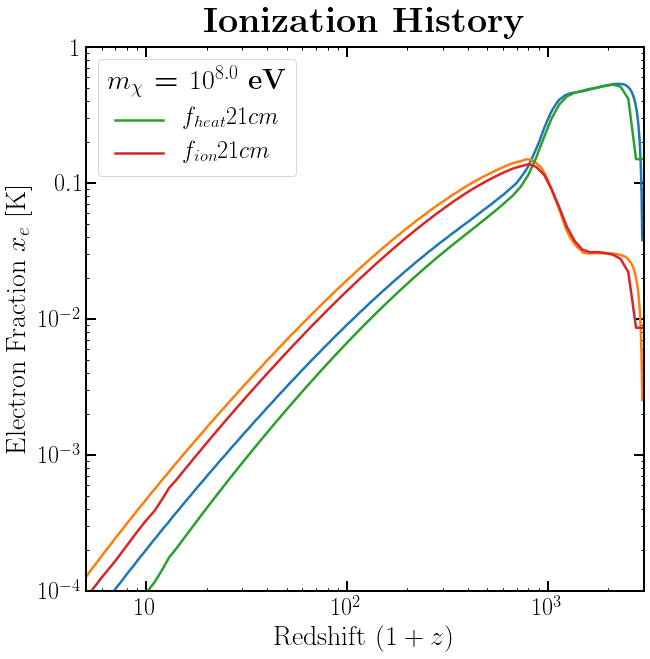

In [670]:
mDM=10**8
soln = np.loadtxt(open("/home/gridgway/Desktop/DarkHistory/darkhistory/history/recfast_standard.txt", "rb"))
tmp = np.array([f_heating(rs,xe) for rs,xe in zip(soln[:,0], soln[:,1])])
tmp2 = np.array([f_H_ion(rs,xe) for rs,xe in zip(soln[:,0], soln[:,1])])

plt.figure()
plt_0, = plt.plot(a1[3].rs[1:], a1[5][:,3], label='$f_{heat}$')
plt_1, = plt.plot(a1[3].rs[1:], a1[5][:,0], label='$f_{ion}$')
plt_2, = plt.plot(soln[:,0], tmp, label='$f_{heat} 21cm$')
plt_3, = plt.plot(soln[:,0], tmp2, label='$f_{ion} 21cm$')

# plt_2, = plt.plot(a2[3].rs[1:], a2[5][:,3], label='$f_{ion}$')
# plt_3, = plt.plot(a2[3].rs[1:], a2[5][:,0], label='$f_{heat}$')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_2, plt_3],#, plt_2, plt_3],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 3e3, 1e-4, 1])
# plt.savefig('/home/gridgway/Desktop/shifted_fs.png')

[5, 2000.0, 0.0001, 1]

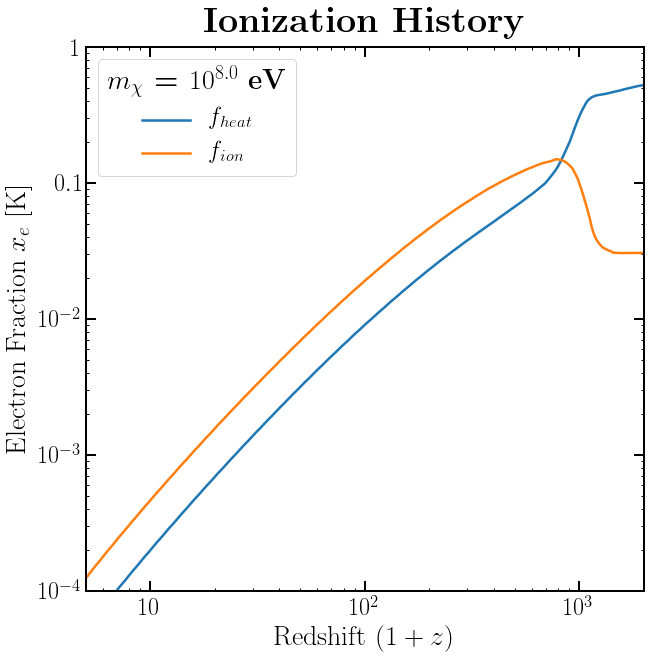

In [399]:
plt.figure()
plt_0, = plt.plot(a1[3].rs[1:], a1[5][:,3], label='$f_{heat}$')
plt_1, = plt.plot(a1[3].rs[1:], a1[5][:,0], label='$f_{ion}$')

# plt_2, = plt.plot(a2[3].rs[1:], a2[5][:,3], label='$f_{ion}$')
# plt_3, = plt.plot(a2[3].rs[1:], a2[5][:,0], label='$f_{heat}$')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_0, plt_1],#, plt_2, plt_3],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 1])
# plt.savefig('/home/gridgway/Desktop/shifted_fs.png')

In [56]:
10**5.778

599791.0762555088

In [60]:
np.log10(6*10**5)

5.778151250383644

In [52]:
hdul = fits.open(
    '/home/gridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/'+
    #'tf_z_3.000E+03_nstep_6398_logE_8.000E+00_xe_0.000E+00.fits'
    'tf_z_3.000E+03_nstep_6398_logE_5.778E+00_xe_0.000E+00.fits'
)

In [53]:
data = hdul[1].data

In [54]:
data.columns.info()

name:
    ['DEPOSITEDENERGY', 'DEP_PROMPT', 'DEP_HIGHENERGY', 'DEP_CASCADES', 'DEP_PHOTOION', 'DEP_COMPTON', 'DEP_LOW', 'DEP_LOW60', 'LOWERBOUND', 'REDSHIFTLOSS', 'PHOTONSPECTRUM', 'COMPTON_ELEC_SPEC', 'HIONFRACTION', 'HEIONFRACTION', 'ENERGY', 'ELECENG', 'REDSHIFT', 'ENERGYCONSERVATION', 'H0', 'OMEGA_M', 'OMEGA_B', 'OMEGA_RAD', 'OMEGA_LAM', 'T_CMB0', 'YHE', 'HUBBLERATE', 'MWIMP', 'CHANNEL', 'SIGMAV', 'ANNRATE', 'IONHIST_VERSION', 'HIGHDEPOSITED', 'HIGHDEP_PROMPT', 'HIGHDEP_HIGHENERGY', 'HIGHDEP_CASCADES', 'HIGHDEP_PHOTOION', 'HIGHDEP_COMPTON', 'HIGHDEP_LOW', 'HIGHDEP_LOW60', 'DEPOSITIONPARTITIONVALS', 'LOWENGELEC', 'LOWENGPHOT', 'LOWENGPHOT_DEPOSITED', 'LOWENGPHOT_CONT', 'CMBLOSSTABLE', 'HIGHDEPOSITED_GRID', 'HIGHDEP_PROMPT_GRID', 'HIGHDEP_HIGHENERGY_GRID', 'HIGHDEP_CASCADES_GRID', 'HIGHDEP_PHOTOION_GRID', 'HIGHDEP_COMPTON_GRID', 'HIGHDEP_LOW_GRID', 'HIGHDEP_LOW60_GRID', 'LOWENGPHOT_ELEMENTGRID', 'LOWENGPHOT_ELEMENTGRID_DEPOSITED']
format:
    ['6398D', '6398D', '6398D', '6398D', '639

In [55]:
print(data.field('redshift').size, data.field('energy').size)

6398 500


In [88]:
# a1[3].switch_spec_type()
# a1[4].switch_spec_type()

In [85]:
rs_list = data.field('redshift')[0][2::2]
photeng = data.field('energy')[0]
eleceng = data.field('eleceng')[0]
hubbles = data.field('hubblerate')[0][2::2]

In [162]:
photTmp = data.field('lowengphot')[0]
photTmp = np.array([photTmp[i] + photTmp[i+1] for i in np.arange(1,len(photTmp)-1,2)])
phot_spectra = Spectra(photTmp, eng=photeng, rs=rs_list, spec_type='dNdE')

elecTmp = data.field('lowengelec')[0]
elecTmp = np.array([elecTmp[i] + elecTmp[i+1] for i in np.arange(1,len(elecTmp)-1,2)])
elec_spectra = Spectra(elecTmp, eng=eleceng, rs=rs_list, spec_type='dNdE')

In [161]:
a1[3].rs[0]

2994.005996001995

In [160]:
data.field('redshift')[0][3]

2991.0134865101163

In [127]:
%autoreload
sum(a1[3].toteng(bound_type='eng', bound_arr = np.array([10.2,11.2, 13.6]))[:,ind])


2.561819599633144e-26

In [166]:
phot_spectra.toteng(bound_type='eng', bound_arr = np.array([10.2,11.2,13.6]))

ValueError: non-broadcastable output operand with shape () doesn't match the broadcast shape (3198,)

In [96]:
phot_spectra.toteng()[ind]/a1[3].toteng()[ind]

1.6561197899853946

In [175]:
phot_spectra.eng[152]

12.805293571594847

In [178]:
a1[3][ind].dNdE[152]

9.111659516736009e-31

In [177]:
print("rs:", data.field('redshift')[0][2*ind + 2])
photTmp = data.field('lowengphot')[0]
photTmp[2*ind + 1][152] + photTmp[2*ind + 2][152]

rs: 99.91977036740958


1.6100435713384872e-26

In [ ]:
log10()

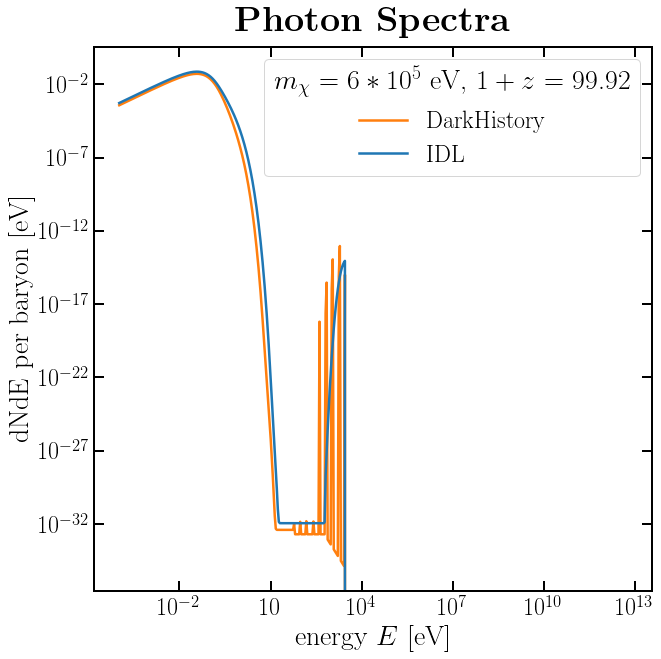

In [182]:
%autoreload
ind=1700
plt.figure()
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

a1[3].plot(ax=ax, ind=rs_list[ind], indtype='rs', label='stuff2', color='C1')
phot_spectra.plot(ax=ax, ind=rs_list[ind], indtype='rs', label='stuff', color='C0')


plt.title(r'\bf{Photon Spectra}')
plt.xlabel(r'energy $E$ [eV]')
plt.ylabel(r'dNdE per baryon [eV]')
leg = ax.legend(['DarkHistory', 'IDL'], title='$m_\chi$ = $6*10^5$ eV, $1+z$ = '+str(round(rs_list[ind],2)), loc=1)
plt.setp(leg.get_title(),fontsize=28)
# ax.text(1e7,1e-14,'rs = '+str(rs_list[ind]))
plt.savefig('/home/gridgway/Desktop/phot_spectra.png')
plt.show()



In [683]:
print(
    'PHOTONS\n',
    'IDL: ',
    phot_spectra.toteng(),
    "\nDarkHistory: ", a1[3].toteng()[:-1]
)

PHOTONS
 IDL:  [6.79859400e-08 2.15037835e-07 4.14020781e-07 ... 8.01608216e-05
 8.01550904e-05 8.01491228e-05] 
DarkHistory:  [1.53649303e-06 4.15859807e-06 7.11816013e-06 1.01767679e-05
 1.32048081e-05 1.61281160e-05 1.89052544e-05 2.15146339e-05
 2.39468660e-05 2.62001439e-05 2.82774013e-05 3.01845221e-05
 3.19291820e-05 3.35200783e-05 3.49664035e-05 3.62774812e-05
 3.74625098e-05 3.85890612e-05 3.96905292e-05 4.07084517e-05
 4.16463836e-05 4.25091833e-05 4.33017594e-05 4.40289334e-05
 4.46953060e-05 4.53051775e-05 4.58625072e-05 4.63708990e-05
 4.68336031e-05 4.72535278e-05 4.76332570e-05 4.79750701e-05
 4.82809640e-05 4.85526744e-05 4.89456468e-05 4.93393203e-05
 4.97143426e-05 5.00697836e-05 5.04052651e-05 5.07206701e-05
 5.10160584e-05 5.12915817e-05 5.15474247e-05 5.17837664e-05
 5.20007569e-05 5.21985039e-05 5.23770654e-05 5.25364463e-05
 5.26765979e-05 5.27974186e-05 5.29647401e-05 5.32428935e-05
 5.35150904e-05 5.37776274e-05 5.40291828e-05 5.42686531e-05
 5.44951712e-05 5.4

In [684]:
print(
    'ELECTRONS\n',
    'IDL: ',
    elec_spectra.toteng(),
    "\nDarkHistory: ", a1[4].toteng()[:-1]
)

ELECTRONS
 IDL:  [6.62991378e-09 1.97457800e-08 3.66752815e-08 ... 3.90886193e-07
 3.91247076e-07 3.91608080e-07] 
DarkHistory:  [1.44214512e-07 3.94449111e-07 6.84725638e-07 9.94432255e-07
 1.31056582e-06 1.62430421e-06 1.92972835e-06 2.22299493e-06
 2.50175079e-06 2.76471087e-06 3.01135091e-06 3.24168198e-06
 3.45608433e-06 3.65518460e-06 3.83976512e-06 4.01069725e-06
 4.16889279e-06 4.31843933e-06 4.46145177e-06 4.59517454e-06
 4.72040297e-06 4.83781109e-06 4.94802345e-06 5.05162347e-06
 5.14915292e-06 5.24111143e-06 5.32795685e-06 5.41010634e-06
 5.48793800e-06 5.56179281e-06 5.63197686e-06 5.69876360e-06
 5.76239623e-06 5.82308994e-06 5.88892003e-06 5.95398856e-06
 6.01729593e-06 6.07889990e-06 6.13885660e-06 6.19720962e-06
 6.25399764e-06 6.30925544e-06 6.36301382e-06 6.41529931e-06
 6.46613394e-06 6.51553509e-06 6.56351535e-06 6.61008252e-06
 6.65523961e-06 6.69898489e-06 6.74613782e-06 6.80130096e-06
 6.85587491e-06 6.90985854e-06 6.96320726e-06 7.01585700e-06
 7.06774435e-06 7

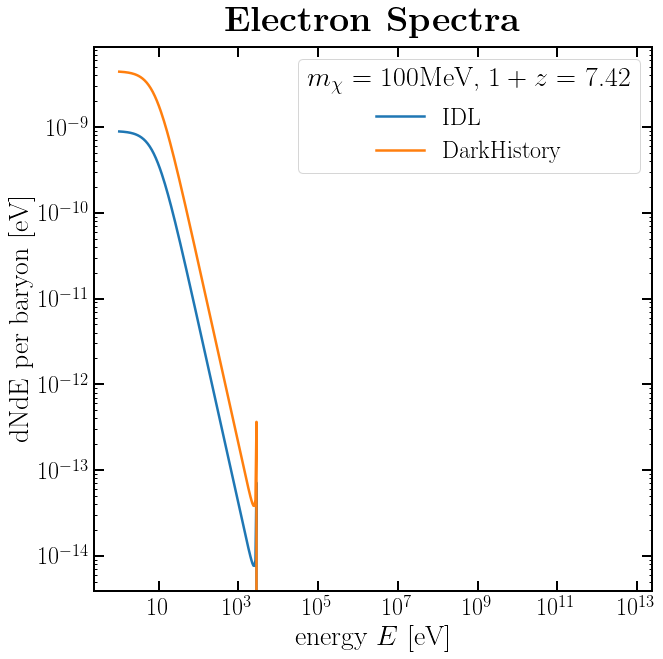

In [692]:
ind=3000
plt.figure()
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

elec_spectra.plot(ax=ax, ind=rs_list[ind], indtype='rs', label='stuff')
a1[4].plot(ax=ax, ind=rs_list[ind], indtype='rs', label='stuff2', fac=1)

plt.title(r'\bf{Electron Spectra}')
plt.xlabel(r'energy $E$ [eV]')
plt.ylabel(r'dNdE per baryon [eV]')
leg = ax.legend(['IDL','DarkHistory'], title='$m_\chi$ = 100MeV, $1+z$ = '+str(round(rs_list[ind],2)), loc=1)
plt.setp(leg.get_title(),fontsize=28)
plt.savefig('/home/gridgway/Desktop/elec_spectra.png')
plt.show()

In [448]:
import darkhistory.low_energy as low_eng
ind=2100
mask = np.zeros_like(rs_list)
mask[ind]=1

mask2 = np.zeros_like(a1[3].rs)
mask2[ind]=1

tmp_phot = phot_spectra.sum_specs(mask)
tmp_phot2 = a1[3].sum_specs(mask2)

tmp_elec = phot_spectra.sum_specs(mask)
tmp_phot2 = a1[3].sum_specs(mask2)

fDH = low_eng.lowE_photons.compute_fs(
    tmp_phot2,
    np.array([1-data.field('hionfraction')[0], 0 ,0]),
    1,
    1
)

fIDL = low_eng.lowE_photons.compute_fs(
    tmp_phot,
    np.array([1-data.field('hionfraction')[0], 0 ,0]),
    1,
    1
)

print('IDL: ', fIDL, '\nDH: ', fDH)

IDL:  [-3.82317469e-12 -5.14115370e-13 -2.54895274e-12  0.00000000e+00
  0.00000000e+00] 
DH:  [-4.02419658e-12 -4.73993831e-13 -1.97800941e-12  0.00000000e+00
  0.00000000e+00]


In [ ]:
ind=2000

mask = np.zeros_like(rs_list)
mask[ind]=1

tmp_phot = phot_spectra.sum_specs(mask)
tmp_elec = elec_spectra.sum_specs(mask)

# Stop Hitting shift-enter now, Hongwan---------

[5, 2000.0, 1, 10000.0]

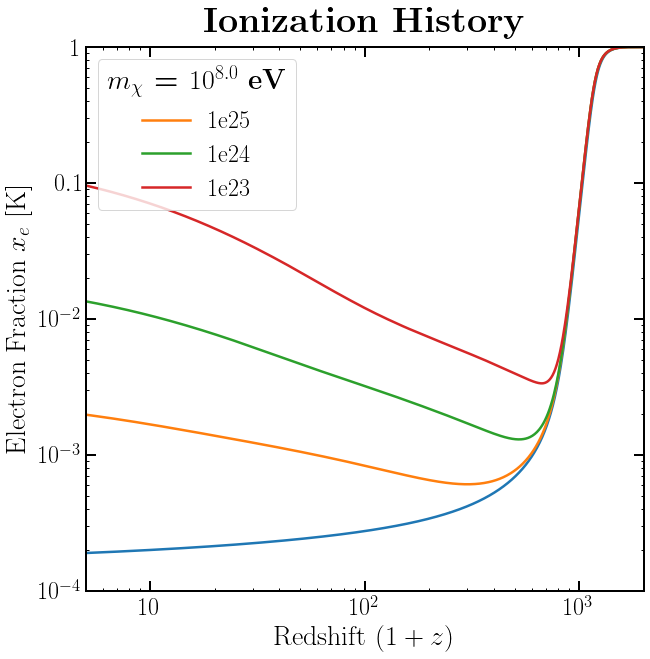

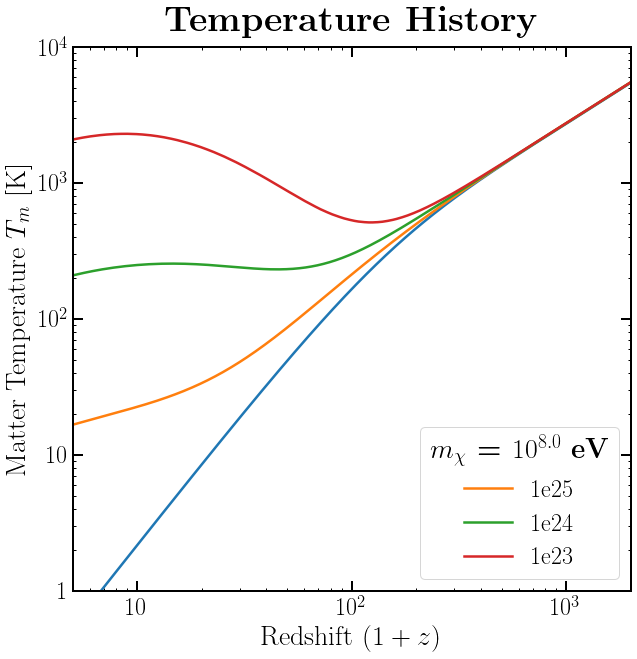

In [121]:
plt.figure()
plt_0, = plt.plot(soln[0,:], soln[2,:], label='None')
plt_3, = plt.plot(b3[3].rs, b3[0], label='1e25')
plt_2, = plt.plot(b2[3].rs, b2[0], label='1e24')
plt_1, = plt.plot(b1[3].rs, b1[0], label='1e23')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_3, plt_2, plt_1],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 1])
#plt.savefig('/home/gridgway/Desktop/xe_decay_comparison.png')

plt.figure()
plt_T0, = plt.plot(soln[0,:], soln[1,:]/phys.kB, label='None')
plt_T3, = plt.plot(b3[3].rs, b3[1]/phys.kB, label='1e25')
plt_T2, = plt.plot(b2[3].rs, b2[1]/phys.kB, label='1e24')
plt_T1, = plt.plot(b1[3].rs, b1[1]/phys.kB, label='1e23')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_T3, plt_T2, plt_T1],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=4
                 )
plt.setp(leg2.get_title(),fontsize=28)
plt.axis([5, 2e3, 1, 1e4])
#plt.savefig('/home/gridgway/Desktop/Tm_decay_comparison.png')

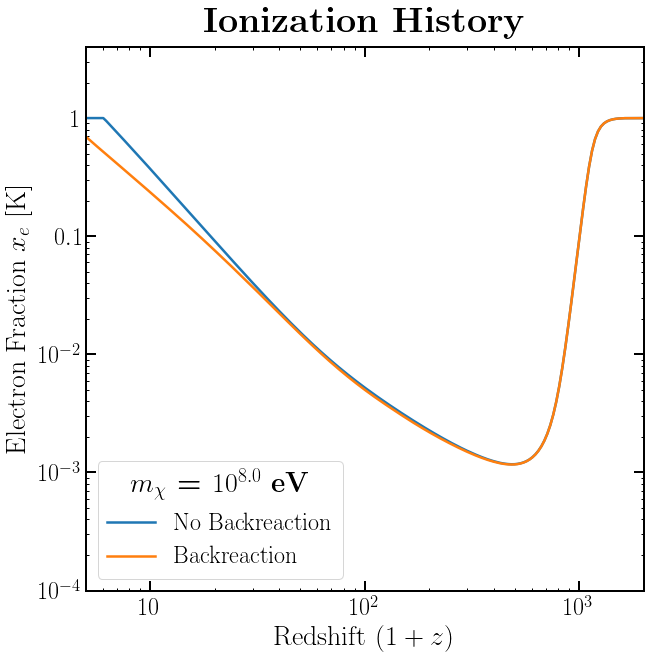

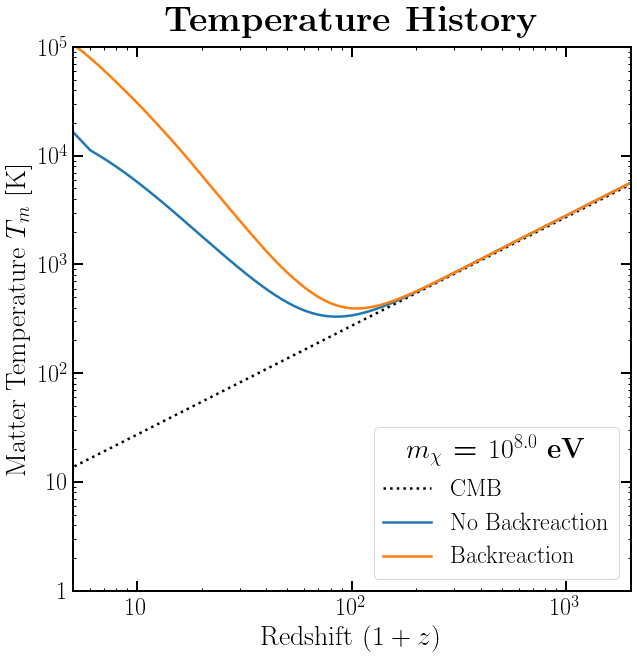

In [144]:
plt.figure()
plt_xe_std, = plt.plot(a[3].rs, a[0], label='No Backreaction')
plt_xe_backReact, = plt.plot(b[3].rs, b[0], label='Backreaction')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_xe_std, plt_xe_backReact],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=3
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 4])
plt.savefig('/home/gridgway/Desktop/xe_elec.png')

plt.figure()
plt_TCMB, = plt.plot(a[3].rs, phys.TCMB(a[3].rs)/phys.kB, 'k:', label='CMB')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='No Backreaction')
plt_Tm_backReact, = plt.plot(b[3].rs, b[1]/phys.kB, label='Backreaction')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_TCMB, plt_Tm_std, plt_Tm_backReact],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=4
                 )
plt.setp(leg2.get_title(),fontsize=28)
plt.axis([5, 2e3, 1, 1e5])
plt.savefig('/home/gridgway/Desktop/Tm_elec.png')

## Generate $f_c(z)$ contour plots

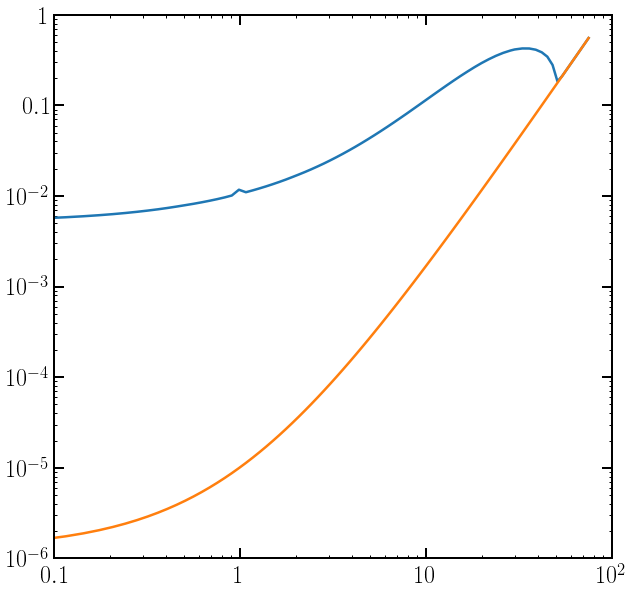

In [151]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(struct_data[:,0]-1, [np.sqrt(struct_boost(rs))*phys.rho_DM*rs**3*1e-9 for rs in struct_data[:,0]])
plt.plot(struct_data[:,0]-1, [phys.rho_DM*rs**3*1e-9 for rs in struct_data[:,0]])
plt.axis([1e-1, 1e2, 1e-6, 1])
plt.show()

In [696]:
fz_elec_decay = np.loadtxt('/home/gridgway/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0]

struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))
log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))
def struct_boost(rs):
    if rs<76:
        return np.exp(log_struct_interp(np.log(rs)))
    else:
        return 1

def rate_func_decay_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)/Ecom
def rate_func_decay_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau) 

def rate_func_swave_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
def rate_func_swave_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs) 

photeng = highengphot_tf_interp.eng
eleceng = lowengelec_tf_interp.eng

In [710]:
mDM/2-phys.me

5109.989461000019

In [714]:
%autoreload
inj_type='decay'
mDM=2*phys.me*1.01
end_rs = 5
Ecom=mDM
tau=1e26
phot_spec_init = Spectrum(photeng,
                         np.zeros_like(photeng),
                         spec_type='N',
                         rs=3000)
elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                  np.array([mDM/2-phys.me]), 
                                  eleceng)
elec_spec_init.rs = 3000
elec_spec_init.switch_spec_type()

data_elec = main.evolve(
    elec_spec_init, phot_spec_init*0,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=16, std_soln=True,
    reion_switch=False
)

TypeError: weight must be an ndarray or spectrum.

### decay, photons

In [648]:
%autoreload
inj_type='decay'
end_rs = 5
sigmav = 3e-26#1e-26
f_decay_phot = []
for i,mDM in enumerate(tqdm(10**log10eng)):
    Ecom=mDM
    tau=1e25
    phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      photeng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()
    elec_spec_init = 0*phot_spec_init

    data_phot = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        #ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=4, std_soln=True,
        struct_boost=None,
        reion_switch=False
    )
    
    f_decay_phot.append(data_phot[5])

rs_list_phot = data_phot[3].rs
f_decay_phot = np.array(f_decay_phot)

pickle.dump(f_decay_phot, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "wb"))

### decay, electrons

In [628]:
%autoreload
inj_type='decay'
end_rs = 5
sigmav = 3e-27#1e-26
f_decay_elec = []
for i,mDM in enumerate(tqdm(10**log10eng[10:])):
    Ecom=mDM
    tau=1e26
    phot_spec_init = Spectrum(photeng,
                             np.zeros_like(photeng),
                             spec_type='N',
                             rs=3000)
    elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2-phys.me]), 
                                      eleceng)
    elec_spec_init.rs = 3000
    elec_spec_init.switch_spec_type()
    
    data_elec = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=16, std_soln=True,
        reion_switch=False
    )
    
    f_decay_elec.append(data_elec[5])

rs_list_elec = data_elec[3].rs
f_decay_elec = np.array(f_decay_elec)

pickle.dump(f_decay_elec, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_elec.p", "wb"))

/home/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


### swave, photons

In [649]:
%autoreload
inj_type='swave'
end_rs = 5
sigmav = 1e-33#1e-26
tau=1e25
f_swave_phot = []
for i,mDM in enumerate(tqdm(10**log10eng[:-2])):
    Ecom=2*mDM
    phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM]), 
                                      highengphot_tf_interp.eng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()
    elec_spec_init = 0*phot_spec_init

    data_phot = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_swave_N, rate_func_swave_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=4, std_soln=True,
        struct_boost=struct_boost,
        reion_switch=False
    )
    
    f_swave_phot.append(data_phot[5])

rs_list_phot = data_phot[3].rs
f_swave_phot = np.array(f_swave_phot)

pickle.dump(f_swave_phot, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_phot.p", "wb"))

### swave, electrons

In [629]:
%autoreload
inj_type='swave'
end_rs = 5
sigmav = 1e-33#1e-26
tau=1e24
f_swave_elec = []
for i,mDM in enumerate(tqdm(10**log10eng[9:-2])):
    Ecom=2*mDM
    phot_spec_init = Spectrum(photeng,
                             np.zeros_like(photeng),
                             spec_type='N',
                             rs=3000)
    elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM-phys.me]), 
                                      eleceng)
    elec_spec_init.rs = 3000
    elec_spec_init.switch_spec_type()
    
    data_elec = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_swave_N, rate_func_swave_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=16, std_soln=True,
        struct_boost=struct_boost,
        reion_switch=False
    )

    f_swave_elec.append(data_elec[5])

rs_list_elec = data_elec[3].rs
f_swave_elec = np.array(f_swave_elec)

pickle.dump(f_swave_elec, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_elec.p", "wb"))

In [550]:
f_decay_elec = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_elec.p", "rb"))
f_decay_phot = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "rb"))
f_swave_elec = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_elec.p", "rb"))
f_swave_phot = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_phot.p", "rb"))

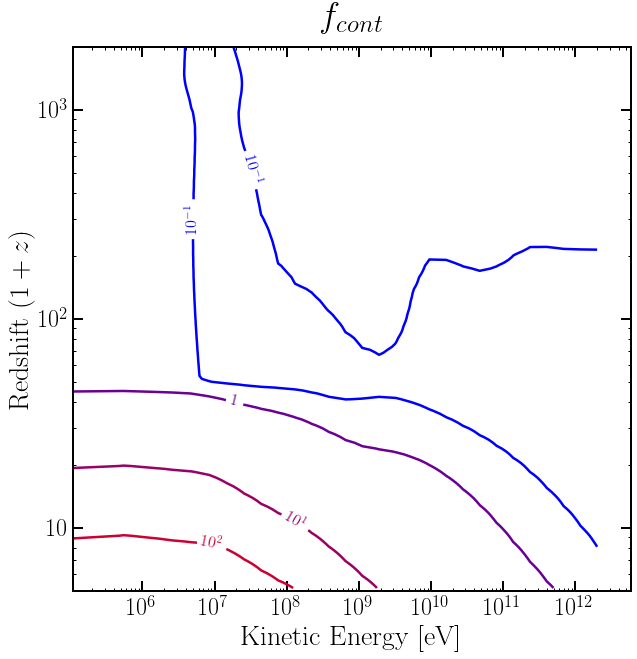

In [646]:
get_fcontour('swave','elec','cont')

In [634]:
def get_fcontour(inj_type, inj_particle, channel):
    if inj_particle is 'elec':
        coarsen_factor = 16

        if inj_type is 'decay':
            f_for_plot = f_decay_elec
            eng=10**log10eng[10:]/2-phys.me
            folder='elec_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_elec
            eng=10**log10eng[9:-2]-phys.me
            folder='elec_swave/'
    else:
        coarsen_factor = 4

        if inj_type is 'decay':
            f_for_plot = f_decay_phot
            eng=10**log10eng/2
            folder='phot_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_phot
            eng=10**log10eng[:-2]
            folder='phot_swave/'

    rs_list = [3000*np.exp(-0.002*coarsen_factor*(i+1)) for i in np.arange(3200/coarsen_factor-1)]

    if channel is 'H_ion':
        ind=0
        title = r'\bf{$f_{H ion}$}'
    elif channel is 'He_ion':
        ind=1
        title = r'\bf{$f_{He ion}$}'
    elif channel is 'exc':
        ind=2
        title = r'\bf{$f_{exc}$}'
    elif channel is 'heat':
        ind=3
        title = r'\bf{$f_{heat}$}'
    elif channel is 'cont':
        ind=4
        title = r'\bf{$f_{cont}$}'

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    if (inj_type is 'decay') or (channel is 'He_ion'):
        labels = { 
            -4:r'$10^{-4}$', 
            -3:r'$10^{-3}$',
            -2:r'$10^{-2}$',
            -1:r'$10^{-1}$',
            0:r'$1$'
        }
        levels=[-4, -3, -2, -1, 0]
    elif inj_type is 'swave':
        if inj_particle is 'phot':
            labels = { 
                -2:r'$10^{-2}$', 
                -1:r'$10^{-1}$',
                0:r'$1$',
                1:r'$10^{1}$',
                2:r'$10^{2}$'
            }
            levels=[-2, -1, 0, 1, 2]
        else:
            labels = { 
                -2:r'$10^{-2}$', 
                0:r'$10^{-1}$',
                1:r'$1$',
                3:r'$10^{1}$',
                4:r'$10^{2}$'
            }
            levels=[-2, 0, 1, 3, 4]

    plt_heating = plt.contour(
        eng, rs_list, 
        np.transpose(np.log10(f_for_plot[:,:,ind])),
        levels=levels,
        colors=[
            (0/256,0,256/256),
            (106/256,0,150/256),
            (156/256,0,100/256),
            (206/256,0,50/256), 
            (256/256,0,0/256)
        ]
    )

    plt.clabel(
        plt_heating, inline=True, fontsize=16, rightside_up=True,
        fmt=labels
    )

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

    user='gridgway'
    plt.savefig(
        '/home/gridgway/Dropbox (MIT)/Photon Deposition/plots/f_contours/'+folder+'f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
    )
    plt.show()

# Comparison to old results

# Import $f(z)$

In [233]:
f_heating(10,xe_std(10))

0.0001592616670604331

In [234]:
f_H_ion(54.947,xe_std(54.947))

0.005938699511868189

In [81]:
user = '/home/gridgway'
greg = ''

#---------- Decay ----------#
fz_elec_decay = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}


#---------- s-wave ----------#
fz_elec_swave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_elec_swave[0:70, 1]
log10eng = fz_elec_swave[0:2800:70, 0] 

log10f_elec_swave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_swave[11200:14000,2], (40,70))) 
}

fz_phot_swave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_phot_swave[0:70, 1]
log10eng = fz_phot_swave[0:2800:70, 0] 

log10f_phot_swave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_swave[11200:14000,2], (40,70)))
}

#---------- p-wave ----------#
fz_elec_pwave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_elec_pwave[0:70, 1]
log10eng = fz_elec_pwave[0:2800:70, 0] 

log10f_elec_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_pwave[11200:14000,2], (40,70))) 
}

fz_phot_pwave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_phot_pwave[0:70, 1]
log10eng = fz_phot_pwave[0:2800:70, 0] 

log10f_phot_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_pwave[11200:14000,2], (40,70)))
}


# Heating Processes

In [40]:
def compton_cooling_rate(xe, T_matter, rs):
    """Returns the Compton cooling rate. 

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    T_matter : float
        The matter temperature in eV. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Compton cooling rate in eV/s. 
    """
    return (
        xe / (1 + xe + phys.nHe/phys.nH) * (phys.TCMB(rs) - T_matter)
        * 32 * phys.thomson_xsec * phys.stefboltz
        * phys.TCMB(rs)**4 / (3 * phys.me)
    )

# Ionization Processes

In [41]:
def alpha_recomb(T_matter):
    """Case-B recombination coefficient. 

    Parameters
    ----------
    T_matter : float
        The matter temperature. 

    Returns
    -------
    float
        Case-B recombination coefficient in cm^3/s. 
    """ 
    
    # Fudge factor recommended in 1011.3758
    fudge_fac = 1.126

    return (
        fudge_fac * 1e-13 * 4.309 * (1.16405*T_matter)**(-0.6166)
        / (1 + 0.6703 * (1.16405*T_matter)**0.5300)
    )

def beta_ion(T_rad):
    """Case-B photoionization coefficient. 

    Parameters
    ----------
    T_rad : float
        The radiation temperature. 

    Returns
    -------
    float
        Case-B photoionization coefficient in s^-1. 

    """
    reduced_mass = phys.mp*phys.me/(phys.mp + phys.me)
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * reduced_mass * T_rad)
    )
    return (
        (1/de_broglie_wavelength)**3/4 
        * np.exp(-phys.rydberg/4/T_rad) * alpha_recomb(T_rad)
    )

def peebles_C(xe, rs):
    """Returns the Peebles C coefficient. 

    This is the ratio of the total rate for transitions from n = 2 to the ground state to the total rate of all transitions, including ionization.

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    Tm : float
        The matter temperature. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Peebles C factor. 
    """

    # Net rate for 2p to 1s transition, times (1-xe). 
    rate_2p1s = (
        8 * np.pi * phys.hubble(rs)
        /(3*(phys.nH*rs**3 * (phys.c/phys.lya_freq)**3))
    )

    # Net rate for 2s to 1s transition, times (1-xe).
    rate_2s1s = phys.width_2s1s * (1-xe)

    # Net rate for ionization, times (1-xe).
    rate_ion = beta_ion(phys.TCMB(rs)) * (1-xe)

    # Rate is averaged over 3/4 of excited state being in 2p, 1/4 in 2s. 
    return (
        (3*rate_2p1s/4 + rate_2s1s/4)
        /(3*rate_2p1s/4 + rate_2s1s/4 + rate_ion)
    )

# TLA Differential Equation

In [42]:
import darkhistory.physics as phys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad

def get_history(
    init_cond, f_H_ion, f_H_exc, f_heating, 
    dm_injection_rate, dm_injection_param, rs_vec
):
    """Returns the ionization and thermal history of the IGM. 

    Parameters
    ----------
    init_cond : array
        Array containing [initial temperature, initial xe]
    fz_H_ion : function
        f(xe, rs) for hydrogen ionization. 
    fz_H_exc : function
        f(xe, rs) for hydrogen Lyman-alpha excitation. 
    f_heating : function
        f(xe, rs) for heating. 
    dm_injection_rate : function
        Injection rate of DM as a function of redshift, and one parameter (lifetime or cross section). 
    dm_injection_param : float
        The injection parameter (lifetime or cross section).
    rs_vec : ndarray
        Abscissa for the solution. 

    Returns
    -------
    list of ndarray
        [temperature solution (in eV), xe solution]. 

    Note
    ----
    The actual differential equation that we solve is expressed in terms of y = arctanh(2*(xe - 0.5)). 

    """

    def tla_diff_eq(var, rs):
        # Returns an array of values for [dT/dz, dy/dz].
        # var is the [temperature, xe] inputs. 

        def xe(y):
            return 0.5 + 0.5*np.tanh(y)

        def dT_dz(T_matter, y, rs):
            #print(y)
            return (
                2*T_matter/rs - phys.dtdz(rs) * (
                    compton_cooling_rate(xe(y), T_matter, rs)
                    + (
                        1/(1 + xe(y) + phys.nHe/phys.nH)
                        * 2/(3 * phys.nH * rs**3)
                        * f_heating(rs, xe(y))
                        * dm_injection_rate(rs, dm_injection_param)
                    )
                )
            )

        def dy_dz(T_matter, y, rs):
            # Stops any change in y once it exceeds y = 4, or xe = 0.999665
            #print(rs, y)
            if y > 4 and rs < 100:
                return 0
            return (
                2 * np.cosh(y)**2 * phys.dtdz(rs) * (
                    peebles_C(xe(y), rs) * (
                        alpha_recomb(T_matter) * xe(y)**2 * phys.nH * rs**3
                        - (
                            beta_ion(phys.TCMB(rs)) * (1 - xe(y))
                            * np.exp(-phys.lya_eng/T_matter)
                        )
                    )
                    - (
                        f_H_ion(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param)
                        / (phys.rydberg * phys.nH * rs**3)
                    )
                    - (1 - peebles_C(xe(y), rs)) * (
                        f_H_exc(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param) 
                        / (phys.lya_eng * phys.nH * rs**3)
                    )
                )
            )

        T_matter, y = var[0], var[1]
        return [dT_dz(T_matter, y, rs), dy_dz(T_matter, y, rs)]

    mod_init_cond = np.array(init_cond)
    
    if mod_init_cond[1] == 1:
        mod_init_cond[1] = 1 - 1e-12
    
    mod_init_cond[1] = np.arctanh(2*(mod_init_cond[1] - 0.5))

    soln = odeint(tla_diff_eq, mod_init_cond, rs_vec)

    soln[:,1] = 0.5 + 0.5*np.tanh(soln[:,1])

    return soln

# TLA Full Solution

In [71]:
logmDM = 8
mDM = 10**logmDM
if np.log10(mDM) < 6:
    units = 'keV'
    mass = str(mDM/10**3)
elif np.log10(mDM) < 9:
    units = 'MeV'
    mass = str(mDM/10**6)
else:
    units = 'GeV'
    mass = str(int(mDM/10**9))

inj_type = 'decay'
#inj_param = 7e-29
prefactor = 1
exponent = -24
inj_param = prefactor * 10**exponent
#[-30.5, -30, -28.5, -27, -25.5]

# Set all of the fractions and DM injection functions.

def f_0(rs, xe):
    return np.zeros_like(rs)

def f_H_ion(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_ion'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_ion'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_ion'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_H_exc(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_exc'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_exc'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_exc'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_heating(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['heating'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['heating'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['heating'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def dm_injection_rate(rs, param):
    if inj_type == 'decay':
        return phys.rho_DM*rs**3/param
    elif inj_type == 'swave':
        return phys.rho_DM**2*rs**6*param/mDM
    elif inj_type == 'pwave':
        sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
        return phys.rho_DM**2*rs**8*param/mDM*(sigma_1D_B/1e7)**2

rs_start = 3000
init_cond = [phys.TCMB(rs_start), 1]
rs_vec = np.flipud(1 + np.arange(0,rs_start-0.5,0.5))


inj_type = 'decay'
inj_param = 1e24

soln = get_history(init_cond, f_0, f_0, f_0, dm_injection_rate, inj_param, rs_vec)
soln_dec = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec)

[10, 2000.0, 1, 20000.0]

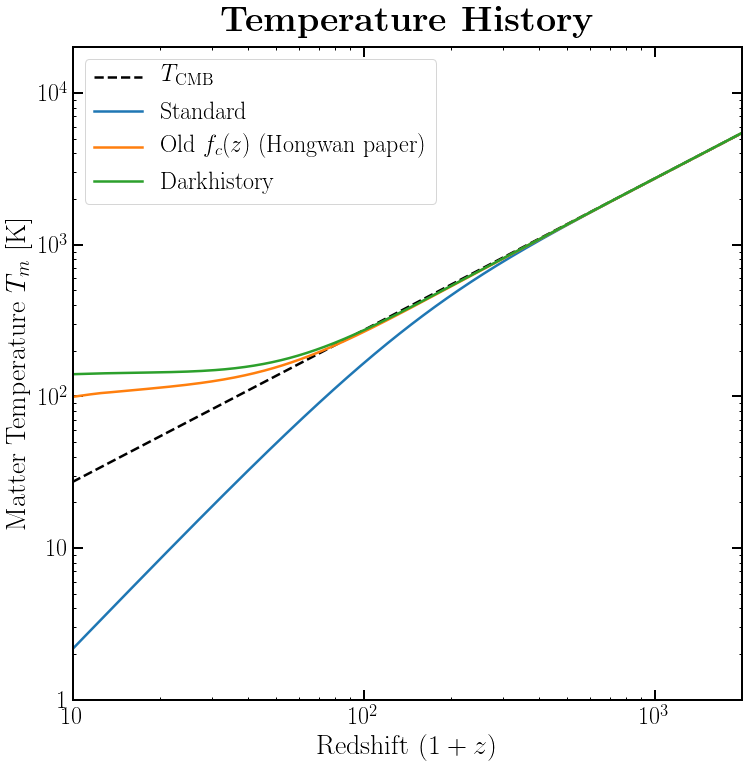

In [86]:
matplotlib.rcParams['figure.figsize'] = [12,12]
plt.figure()

ax = plt.gca()

T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label=r'$T_\mathrm{CMB}$')
T_IGM_std, = plt.plot(std_soln_rs, std_soln_T, label='Standard')
T_IGM_dec, = plt.plot(rs_vec, soln_dec[:,0]/phys.kB, alpha=1.0, label=r'Old $f_c(z)$ (Hongwan paper)')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='Darkhistory')

ax.set_xscale('log')
ax.set_yscale('log')

leg = plt.legend(handles=[T_CMB, T_IGM_std, T_IGM_dec, plt_Tm_std], 
                 #title=r'$m_\chi$\bf{ = '+mass+' '+units+' }',#$(1+z)_\mathrm{td} = 500$',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([10, 2e3, 1, 2e4])

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/T_standard_dec_swave_pwave_constraint.pdf')

# TeVPA Plotting

In [18]:
#Download tau_min and sigma_max

user = 'gridgway'
f_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_electron_extended.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1] 

f_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_photon.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1] 

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def max_xsec_elec_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))
    elif injection_type == 'decay':
        return decay_elec_CMB(mDM*1e-9)

def max_xsec_phot_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))
    elif injection_type == 'decay':
        return decay_phot_CMB(mDM*1e-9)

### Single Temperature History

In [39]:
%autoreload
global user 
user = "gridgway"
end_rs = 5
mDM = 1e8
sigmav = max_xsec_phot_CMB(mDM, 'swave')
tau = max_xsec_phot_CMB(mDM, 'decay')


phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      highengphot_tf_interp.eng)
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)

#!!! What about Reionization
std_data = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=True, user="gridgway"
)

backReact_data = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=False, user="gridgway"
)

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


[None, None]

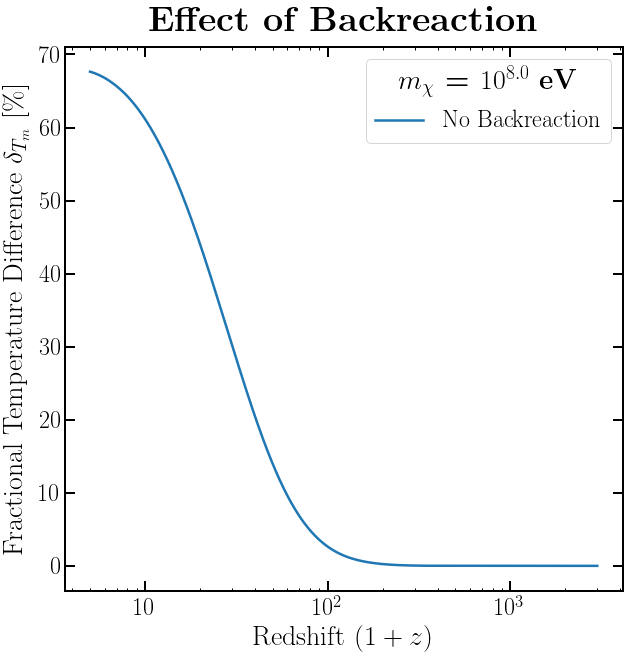

In [50]:
plt.figure()
plt_Tm_diff, = plt.plot(
    std_data[3].rs, np.abs((std_data[1]-backReact_data[1])/std_data[1] * 100), 
    label='No Backreaction'
)

ax = plt.gca()
ax.set_xscale('log')
#ax.set_yscale('log')

plt.title(r'\bf{Effect of Backreaction}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Fractional Temperature Difference $\delta_{T_m}$ [\%]')
leg2 = plt.legend(handles=[plt_Tm_diff],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=1
                 )
plt.setp(leg2.get_title(),fontsize=28)

### rs vs. mDM heat plot of differences

In [62]:
%autoreload

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')
log10eng = fz_phot_decay[0:2800:70, 0]

end_rs = 5

diff_list = []

log10eng = log10eng[2:]

for i,mDM in enumerate(tqdm(10**log10eng)):
    sigmav = max_xsec_phot_CMB(mDM, 'swave')
    tau = max_xsec_phot_CMB(mDM, 'decay')
    
    def rate_func_decay_N(rs):
        # This is dN/dV dt
        return phys.inj_rate('decay', rs, tau=tau)/mDM

    def rate_func_decay_eng(rs):
        # This is dN/dV dt
        return phys.inj_rate('decay', rs, tau=tau)
    
    phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      highengphot_tf_interp.eng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()

    a = main.evolve(
        phot_spec_init*0, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
        coarsen_factor=1, std_soln=True, user="gridgway"
    )
    
    b = main.evolve(
        phot_spec_init*0, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
        coarsen_factor=1, std_soln=False, user="gridgway"
    )
    
    diff_list.append(np.abs((a[1]-b[1])/a[1] * 100))

rs_list = a[3].rs
diff_list = np.array(diff_list)

if(species=='elec'):
    pickle.dump(diff_list, open("/Users/gridgway/Dropbox (MIT)/Photon Deposition/backReact_elec_residuals.p", "wb"))
else:
    pickle.dump(diff_list, open("/Users/gridgway/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals.p", "wb"))

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


Text(0.5,0,'Dark Matter Mass $m_\\chi$ [eV]')

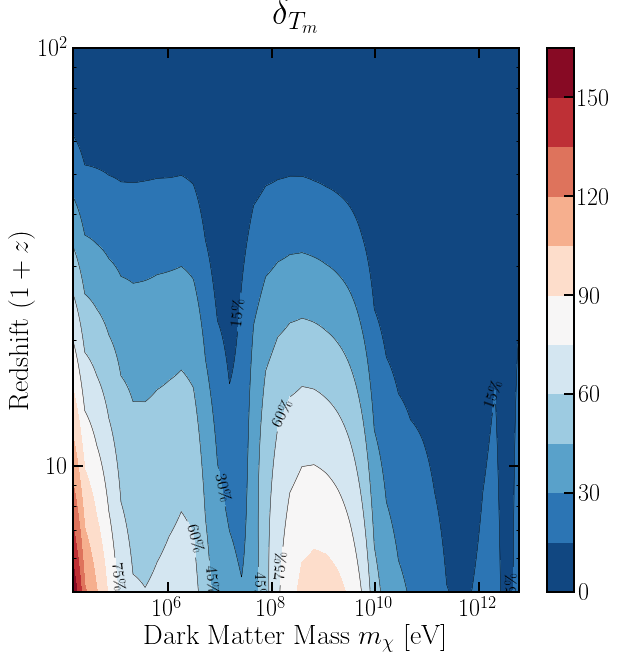

In [19]:
user = 'hongwan'

diff_list = pickle.load(open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals.p', "rb"))

rs_list = np.exp(np.arange(np.log(3000), np.log(5), step=-0.002))

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')
log10eng = fz_phot_decay[0:2800:70, 0]
log10eng = log10eng[2:]


plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt_heating = plt.contour(
    10**log10eng, rs_list, 
    np.transpose(diff_list),
    levels=[15, 30, 45, 60, 75],
    linewidths=0.5,
    colors='k'
#     colors=[
#         (0/256,0,256/256),
#         (106/256,0,150/256),
#         (156/256,0,100/256),
#         (206/256,0,50/256), 
#         (256/256,0,0/256)
#     ]
)

plt.axis([10**log10eng[0], 10**log10eng[-1], 5, 100])

labels = { 
    15:r'$15$\%', 
    30:r'$30$\%',
    45:r'$45$\%',
    60:r'$60$\%',
    75:r'$75$\%'
}

plt.clabel(
    plt_heating, inline=True, fontsize=16, rightside_up=True,
    fmt=labels
)
cntr1 = ax.contourf(10**log10eng, rs_list, np.transpose(diff_list), 14, cmap="RdBu_r")
plt.colorbar(cntr1, ax=ax)

plt.title(r'\bf{$\delta_{T_m}$}')
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

# user='gridgway'
# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/backReact_phot_residuals.pdf')

In [17]:
plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt_heating = plt.contour(
    10**log10eng, rs_list, 
    np.transpose(diff_list),
    levels=[15, 30, 45, 60, 75],
    linewidths=0.5,
    colors='k'
#     colors=[
#         (0/256,0,256/256),
#         (106/256,0,150/256),
#         (156/256,0,100/256),
#         (206/256,0,50/256), 
#         (256/256,0,0/256)
#     ]
)

plt.axis([10**log10eng[0], 10**log10eng[-1], 5, 100])

labels = { 
    15:r'$15$\%', 
    30:r'$30$\%',
    45:r'$45$\%',
    60:r'$60$\%',
    75:r'$75$\%'
}

plt.clabel(
    plt_heating, inline=True, fontsize=16, rightside_up=True,
    fmt=labels
)
cntr1 = ax.contourf(10**log10eng, rs_list, np.transpose(diff_list), 14, cmap="RdBu_r")
plt.colorbar(cntr1, ax=ax)

plt.title(r'\bf{$\delta_{T_m}$}')
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

# user='gridgway'
# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/backReact_phot_residuals.pdf')

(3199,)

# Coarsening

In [57]:
%%prun

a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=1, std_soln=std_soln
)
print("coarsen 1")

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 1
 

In [59]:
74.2/24.7

3.0040485829959516

In [62]:
%%prun

a16 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=4, std_soln=std_soln
)
print("coarsen 16")

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 16
 

In [53]:
%autoreload
%time
end_rs = 5
std_soln=True

a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=1, std_soln=std_soln
)
print("coarsen 1")

a2 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=2, std_soln=std_soln
)
print("coarsen 2")

a4 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=4, std_soln=std_soln
)
print("coarsen 4")

a8 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=8, std_soln=std_soln
)
print("coarsen 8")

a16 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=16, std_soln=std_soln
)
print("coarsen 16")

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 1
coarsen 2
coarsen 4
coarsen 8
coarsen 16
CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 4.77 µs


[None, None]

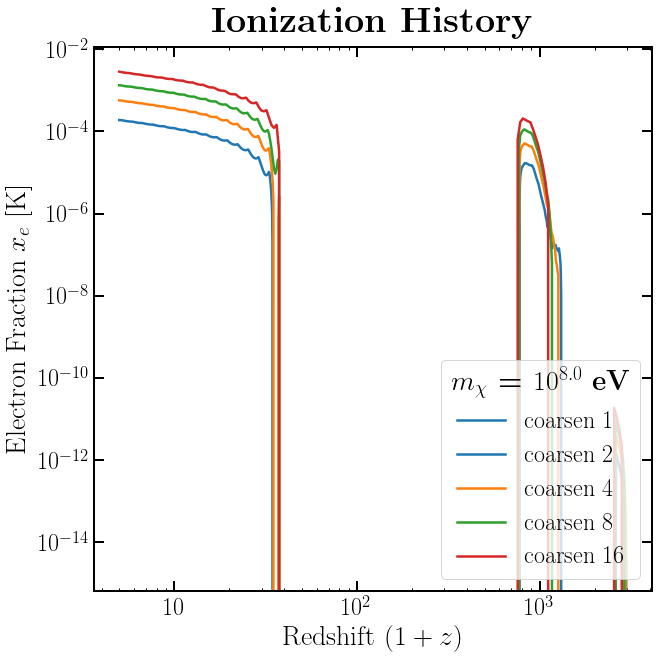

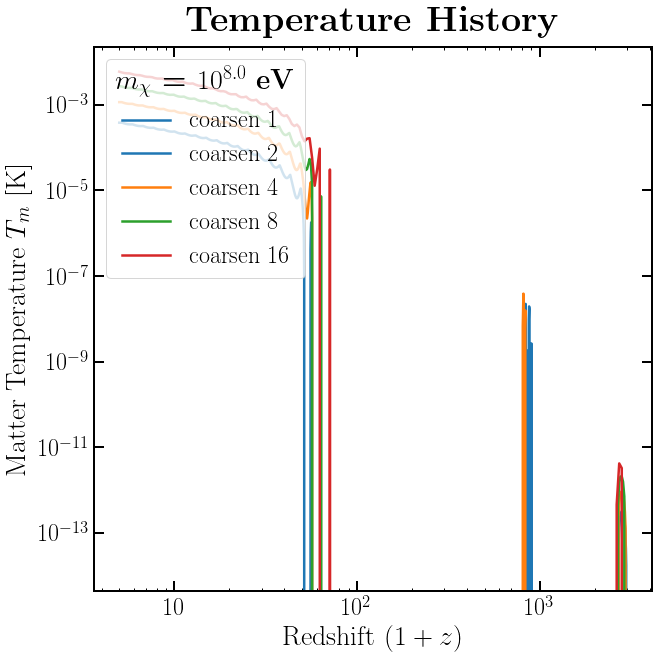

In [56]:
plt.figure()
#plt_1,  = plt.plot(a1[3].rs,  a1[0],  label='coarsen 1')
plt_2,  = plt.plot(a2[3].rs,  (a2[0]-a1[0][::2])/a2[0],  label='coarsen 2')
plt_4,  = plt.plot(a4[3].rs,  (a4[0]-a1[0][::4])/a4[0],  label='coarsen 4')
plt_8,  = plt.plot(a8[3].rs,  (a8[0]-a1[0][::8])/a8[0],  label='coarsen 8')
plt_16, = plt.plot(a16[3].rs, (a16[0]-a1[0][::16])/a16[0], label='coarsen 16')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_1, plt_2, plt_4, plt_8, plt_16],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=4
                )
plt.setp(leg.get_title(),fontsize=28)

plt.figure()
# plt_T1,  = plt.plot(a1[3].rs,  a1[1],  label='coarsen 1')
plt_T2,  = plt.plot(a2[3].rs,  (a2[1]-a1[1][::2])/a2[1],  label='coarsen 2')
plt_T4,  = plt.plot(a4[3].rs,  (a4[1]-a1[1][::4])/a4[1],  label='coarsen 4')
plt_T8,  = plt.plot(a8[3].rs,  (a8[1]-a1[1][::8])/a8[1],  label='coarsen 8')
plt_T16, = plt.plot(a16[3].rs, (a16[1]-a1[1][::16])/a16[1], label='coarsen 16')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_T1, plt_T2, plt_T4, plt_T8, plt_T16],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=2
                 )
plt.setp(leg2.get_title(),fontsize=28)

# Scratch Work

[20000.0, 1000000000000.0, 6e+22, 1e+31]

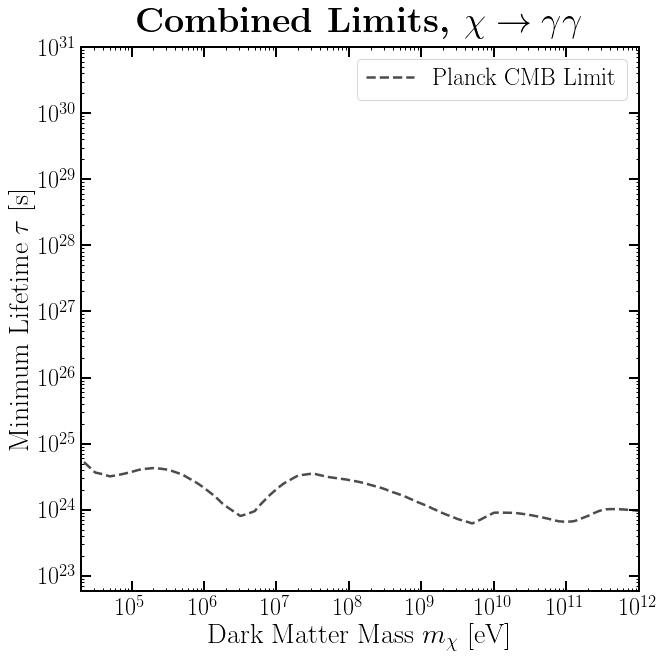

In [21]:
log10mDM_fine = np.log10(10**np.arange(4, 12.5, 0.05) + 2*phys.me*0)
log10tau_fine = np.arange(22, 30, 0.05)
lim_CMB, = plt.plot(
    10**log10mDM_fine, max_xsec_phot_CMB(10**log10mDM_fine, 'decay'), 
    color='black', alpha=0.7, linestyle='dashed'
)

lim_CMB.set_label(r'Planck CMB Limit')

leg = plt.legend(loc=1)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Combined Limits}, $\chi \to \gamma \gamma$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.ylabel(r'Minimum Lifetime $\tau$ [s]')
plt.axis([2e4, 1e12, 6e22, 1e31])

In [154]:
# p-wave structure formation
NFW_subs_data = []
with open('/home/gridgway/Dropbox (MIT)/21cm_pwave/math/data/rho_eff_NFW_subs_pwave.txt') as f:
    for line in f:
        inner_list = [float(num.strip()) for num in line.split(' ') if num]
        NFW_subs_data.append(inner_list)
        
NFW_subs_data = np.array(NFW_subs_data)
NFW_subs_data[:,2] *= .839418
NFW_subs_data[:,0] += 1
sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
NFW_subs_data[:,1] = phys.rho_DM * NFW_subs_data[:,0]**4 * 10**-9 * sigma_1D_B/phys.c

struct_boost_raw = (NFW_subs_data[:,2]/NFW_subs_data[:,1])**2

log10_struct_boost = interp1d(NFW_subs_data[:,0], np.log10(struct_boost_raw))

def struct_boost(rs):
    if rs < NFW_subs_data[-1,0]:
        return 10**log10_struct_boost(rs)
    else:
        return 1.

- RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded

- why are there fewer energy bins in CMB_engloss_arr than the tflists?

In [52]:
CMB_engloss_arr.shape

(11, 321, 51)

In [151]:
# Spectra of CMB as a function of rs
eng = a[3].eng
CMB_spectra = Spectra([
    Spectrum(
        eng, 
        5e-9*phys.CMB_spec(eng, phys.TCMB(rs)) * 
        CMB_engloss_interp(min(a[0][i], .999), rs) * phys.nB*rs**3 * highengphot_tf_interp.dlnz/phys.hubble(rs) / np.sum(
            np.insert(np.diff(eng), 0, eng[1]-eng[0]) * eng * phys.CMB_spec(eng, phys.TCMB(rs))
        ), 
        rs=rs
    )
    for i, rs in enumerate(a[3].rs)
])
CMB_spectra.switch_spec_type()

In [136]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])
CMB_engloss_interp = interp2d(xes, highengphot_tf_interp.rs, np.transpose(np.sum(CMB_engloss_arr, 1)))

[0.0001, 10000.0, 1e-44, 5000]

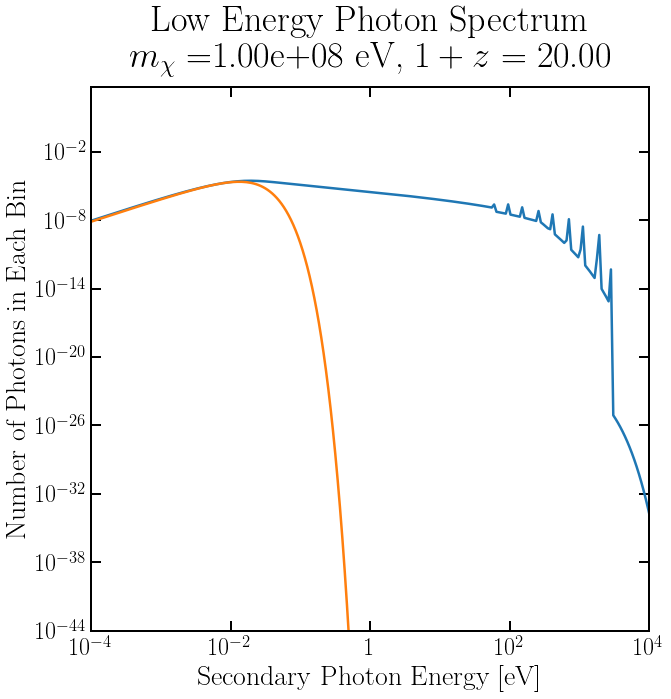

In [152]:
plt.figure()

rs_plot = 20.0

ax = plt.gca()
tf_plot, = a[3].plot(ax, ind=rs_plot, fac=1, indtype='rs')
CMB_plot, = CMB_spectra.plot(ax, ind=rs_plot, indtype='rs')
# tf_plot, = lowengphot_spectra.plot(ax, ind=20)


ax.set_xscale('log')
ax.set_yscale('log')

plt.title('Low Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mDM)
          +r' eV, $1+z$ = '+'{0:.2f}'.format(rs_plot)
         )

#ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))


plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 1e4, 1e-44, 5000])

#plt.savefig('/home/gridgway/Desktop/CMB_subtract.png')

In [230]:
temp2 = np.array([
    np.append(rs,compute_fs(
        Spectrum(temp[3].eng, elec_spec, rs=rs, spec_type='N'), 
        Spectrum(temp[3].eng, phot_spec, rs=rs, spec_type='N'),
        np.array([1-xe, 0, 0]), 
        rate_func_decay_eng(rs), 
        highengphot_tf_interp.dlnz/phys.hubble(rs)
    ))
    for (rs, xe, phot_spec, elec_spec) in zip(temp[3].rs[1:], temp[0][1:], temp[3], temp[4])
])
print(temp2[-20:])

AttributeError: 'numpy.ndarray' object has no attribute 'rs'

# NEED TO CHECK

In [393]:
import darkhistory.low_energy.lowE_deposition as lowE_dep
%autoreload

time=-2
tau=1e23
rs_tmp = a1[3][time].rs
print(sum(lowE_dep.compute_fs(
    a1[4][time], 
    a1[3][time], 
    np.array([1-xe_std(rs_tmp),0,0]), 
    rate_func_eng(rs_tmp), 
    .002/phys.hubble(rs_tmp), 
    0
))*rate_func_eng(rs_tmp)*.002/phys.hubble(rs_tmp)/phys.nB/rs_tmp**3)
print(a1[4][time].toteng()+a1[3][time].toteng())

0.0054045385439492315
0.005405394701886692


-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?

-Why don't we go above 5 TeV?

TODO:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation


- Structure Formation
    - swave
    - on/off switch
    - optimistic/conservative
    - (just a change to the annihilation rate)
    
- minimum lifetime (do this first, structure independent)/maximum cross-section
    - residual plot of with back-reaction vs. not back-react (temperature), contour plots
    - for each mass pick the minimum tau or maximum cross-section and compare the std_switch on or off
    
- New 21cm sensitivity
    - Hongwan's plots, but now with DarkHistory